# Projet Python 2A - Julia Nicolas, Mathilde Kubiak, Clara Le Gallic-Ach

# De 1950 à nos jours : évolution de l'industrie cinématographique et étude du cas français

# Introduction et problématisation

Depuis la seconde moitié du XXe siècle on peut observer une multiplicité des supports de diffusion numériques ce qui est l'origine d'un univers multimédia toujours plus concurrentiel. En effet, la démocratisation de la télévision dans les années 1960, sa privatisation dans les années 1980 puis l'émergence des plateformes de téléchargements et de streaming ont offert de nouvelles alternatives au visionnage de films des traditionnelles 'sorties ciné'. Dans ce contexte, quelles ont été les mutations de l'économie du cinéma ?
Notre étude s'appuiera sur l'analyse de milliers de films sortis entre 1950 et 2020 ainsi que sur des données socio-économiques françaises relatives à l’industrie cinématographique. 
Nous commencerons par faire une étude de la composition et de l'évolution du box office aux Etats-unis. Ensuite nous comparerons cette évolution avec l'évolution française et nous approfondirons en analysant les relations entre box office, fréquentation des cinémas, prix des billets, âges et facteurs socio-économiques. Finalement, nous chercherons à mettre en lumière ce qui fait du cinéma une industrie qui sait, malgré ses mutations, toujours être au cœur des habitudes culturelles des français. 



### Importation tous les packages que nous allons utiliser pour notre travail


In [1]:
from requests import get
from bs4 import BeautifulSoup
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.ticker as ticker

# La collecte des données
Nous allons commencer par récupérer les données qui seront utiles à notre analyse. Les données que nous allons utiliser viennent de plusieurs bases :
* **La base IMDb** : une des plus grande base de donnée en ligne sur le cinéma mondial. Nous allons récupérer par webscrapping, pour la période 1950-2020 le titre des films, leur année de sortie, leur chiffre d'affaire et d'autres caractéristiques qui nous semblent pertinentes à relier avec le chiffre d'affaire.
* **Des bases de données du CNC** comptabilisant, de 1950 à 2020, le nombre d'entrées, les recettes des cinémas français, les recettes par entrée et d'autres données sur le public et les préférences de celui-ci.

### 1) Webscraping afin de collecter les données qui nous interessent de la base IMDb

Pour commencer nous avons choisi d'utiliser les données présentes sur le site internet IMDb. IMDb est une base de donnée en ligne sur le cinéma mondial contenant plus de 6,5 millions films. Nous avons choisi cette base de donnée pour sa taille et parce qu'elle nous permettait d'obtenir le 'chiffre d'affaire' de films remontant **des années 1950 à de nos jours**. Ce que le site désigne comme 'chiffre d'affaire' d'un film est en réalité son box office américain.

Grâce à une boucle permettant de faire défiler les pages pendant le scraping et au package `BeautifulSoup4`, nous constituons notre base de données rassemblant les **titre, année, catégorie, genre, réalisateur, durée, metascore, score imdb, nombre de votes et chiffre d'affaire** pour chacun des films. 

**Comment avons-nous procéder ?**

En analysant l'url choisi pour le scraping et la page internet associée, nous comprenons qu'il faut créer une boucle pour changer de page. Une page scrapée représente 50 films. Les données qui nous intéressent se trouvent sur la page principale, c'est à dire que nous n'avons pas besoin de rentrer dans l'url associé à chaque film pour récupérer ses données. C'est une bonne nouvelle car cela va accélérer et faciliter notre scraping.

Nous décidons de récupérer 10 051 films, sachant que certains auront des NaN que nous éliminerons. 

Pour récupérer les caractéristiques que nous voulons, nous créons des tableaux vides que nous allons remplir à chaque boucle. 

> Lors d'une boucle le protocole est tel que :

- Nous indiquons l'url de la page à récupérer
- Grâce au package `BeautifulSoup`, nous lisons la page html afin de repérer le balisage de la page 
- Nous découpons la page html à chaque nouveau film décrit et nous créons une nouvelle boucle par film
- Dans ce 'paragraphe' décrivant un film, nous repérons le balisage associé aux informations choisies
- Pour le titre, le genre, la durée, la catégorie, les scores et l'année de sortie, l'information est relativement simple à récupérer car chaque information est unique et associée à un type unique de balisage.  
- Pour le réalisateur la tâche est plus compliqué car cette informations textuelles est associée à beaucoup d'autres comme le nom des acteurs ou les appelations 'actors', 'directors'. Il faut alors utiliser des méthodes de NLP telles que le `.split()` (transforme une liste de chaines de caractères en liste de mots en séparant à chaque espace) ou le `.strip()` (élimine les espaces inutiles) afin de bien séparer et récupérer chaque mot. Nous récupérons ensuite le ou les noms associés à la fonction de "Director".
- Pour le nombre de votes et le chiffre d'affaire, les deux informations sont aussi liées, il faut les récupérer puis les séparer afin de les ajouter au bon tableau. 
- Pour chaque information, si celle-ci n'est pas disponible nous choisissons de les conserver et de les rendre `NaN`. En effet sans cette option nous aurions un tableau sans `NaN` mais nous voulons d'abord voir à quels types de films sont associés ces `NaN` avant de les supprimer. 

Les informations du premier film sont donc maintenant rangées à la première place de chaque tableau, la boucle va procéder de même pour les 10 050 films suivants en changeant de page tous les 50 films. 


**La prochaine cellule met environ 6 minutes à tourner !**

In [2]:
#Création d'un tableau qui va permettre de faire tourner la boucle et de passer à la page suivante tous les 50 films 

pages = np.arange(1, 10051, 50)


Films = [] 
Années = [] 
Catégories = [] 
Genres = [] 
Durées = [] 
Scores_imdb = [] 
Values=[] 
Votes = [] 
CA = [] 
Metascores=[] 
Réalisateurs = [] 
Acteurs = []

#On scrape 50 films par page puis il faut changer de page grâce à cette boucle 

for page in pages:

    #Récupération de l'url. Sur la page web, on remarque que l'url change après le "start" lorsque l'on passe aux pages suivantes
    R = get("https://www.imdb.com/search/title/?sort=num_votes,desc&" 
                   + "start=" 
                   + str(page) 
                   + "&title_type=feature&year=1950,2020")

    #Utilisation du package BeautifulSoup afin de se repérer dans la page html
    Page = BeautifulSoup(R.text, 'html.parser')

    #Repérage du balisage à chaque film afin de les prendre un par un dans la prochaine boucle
    Concat_films = Page.find_all('div', class_= 'lister-item mode-advanced')

    #Pour chaque film, on repère le balisage des informations voulues et on les stocke 
    for film in Concat_films:


           #Titre
            if film.h3.a is not None:
                Titre = film.h3.a.text
                Films.append(Titre)
            else:
                Titre.append(np.nan)

           #Année de sortie 
            if film.h3.find('span', class_= 'lister-item-year text-muted unbold') is not None:
                Année = film.h3.find('span', class_= 'lister-item-year text-muted unbold').text
                Années.append(Année)
            else:
                Année.append(np.nan)


            #Réalisateur 
            if film.find("p", class_="") is not None:
                Noms = film.find("p", class_="")
                Noms = Noms.text.replace("\n","").split('|')
                Noms = [x.strip() for x in Noms]
                Noms = [Noms[i].replace(j, "") for i,j in enumerate(["Director:"])]
                Réalisateurs.append(Noms[0])
            else : 
                Réalisateurs.append(np.nan)


            #Genre
            if film.find('span', class_ = 'genre') is not None: 
                Genre = film.find('span', class_ = 'genre').text
                Genres.append(Genre)
           # else:
               #  Genre.append(np.nan)

            #Durée
            if film.p.find('span', class_ = 'runtime') is not None: 
                Durée = film.p.find('span', class_ = 'runtime').text
                Durées.append(Durée)
            else:
                Durées.append(np.nan)

            #Score public IMDB
            if film.strong is not None:
                imdb = float(film.strong.text)
                Scores_imdb.append(imdb)
            else: 
                imdb.append(np.nan)

            #Metascore
            if film.find('span', class_ = 'metascore') is not None:
                Metascore = film.find('span', class_ = 'metascore').text
                Metascores.append(int(Metascore))
            else:
                Metascores.append(np.nan)


            #Nombre de votes sur le site IMDB et chiffre d'affaire
            Film_values = film.find_all('span', attrs = {'name':'nv'})
            del Values[:]

            if len(Film_values)==2:
                for value in range(2) :
                    Values.append(Film_values[value]['data-value'])
                Votes.append(int(Values[0]))
                CA.append(Values[1])
            elif len(Film_values)==1:
                Votes.append(int(Film_values[0]['data-value'][0]))
                CA.append(np.nan)
            else :
                Votes.append(np.nan)
                CA.append(np.nan)

Maintenant que nous avons les informations de tous les films dans chacun des tableaux, nous allons les accoler dans un **Dataframe**. 

In [3]:
df = pd.DataFrame({'Film': Films,
                       'Année': Années,
                       'Genre': Genres,
                       'Réalisateur': Réalisateurs,
                       'Durée (min)': Durées,
                       'Metascore': Metascores,
                       'Score imdb': Scores_imdb,
                       'Nb votes': Votes,
                       'CA($)': CA})

Afin d'éviter d'avoir à systématiquement faire tourner ce code nous avons récupéré le csv final obtenu après Webscrapping et réorganisation dans un dataframe. Ce csv est celui intitulé `DFscrap10051`.

In [4]:
df = pd.read_csv('DFscrap10051.csv')
df

,Film,Année,Genre,Réalisateur,Durée (min),Metascore,Score imdb,Nb votes,CA($)
0,Les évadés,(1994),\nDrama,Frank Darabont,142 min,80.0,9.3,2316795,"28,341,469"
1,The Dark Knight: Le chevalier noir,(2008),"\nAction, Crime, Drama",Christopher Nolan,152 min,84.0,9.0,2279150,"534,858,444"
2,Inception,(2010),"\nAction, Adventure, Sci-Fi",Christopher Nolan,148 min,74.0,8.8,2042137,"292,576,195"
3,Fight Club,(1999),\nDrama,David Fincher,139 min,66.0,8.8,1835432,"37,030,102"
4,Pulp Fiction,(1994),"\nCrime, Drama",Quentin Tarantino,154 min,94.0,8.9,1807662,"107,928,762"
...,...,...,...,...,...,...,...,...,...
10045,Braveheart,(1995),"\nBiography, Drama, History",Mel Gibson,178 min,68.0,8.3,952014,"75,600,000"
10046,Le Monde de Nemo,(2003),"\nAnimation, Adventure, Comedy","Directors:Andrew Stanton, Lee Unkrich",100 min,90.0,8.1,940715,"380,843,261"
10047,Le Retour du Jedi,(1983),"\nAction, Adventure, Fantasy",Richard Marquand,131 min,58.0,8.3,940642,"309,125,409"
10048,The Lion King,(1994),"\nAnimation, Adventure, Drama","Directors:Roger Allers, Rob Minkoff",88 min,88.0,8.5,931871,"422,783,777"


Notre dataframe associe bien  les informations que nous voulions à chaque film. De plus le dataframe a bien 10 051 lignes donc aucun `NaN` ou aucune information n'ont été oubliés.

Certaines colonnes ont cependant des aspérités ou des types qu'il est nécessaire de modifier. Nous allons procéder au nettoyage de la base après une étude des valeurs manquantes dans la première partie de notre analyse.

### 2) Récupération des bases de données du CNC

Le CNC est le centre national du cinéma et de l'image animée. C'est un établissement public disposant de nombreux jeux de données certifiés. Nous choisissons la base de données comptabilisant le nombre d'entrées, les recettes des cinémas français et les recettes par entrée de 1950 à 2020. Cela nous permettra de comparer ce l'évolution mondiale au cas français est de regarder ce que dit le box office de la fréquentation des salles de cinéma.

La base de donnée qu'on utilise est au format .csv. Cependant, les données qui nous interessent sont associées à d'autre csv dans un fichier excel à plusieurs feuilles. Nous avons donc extrait les tableaux nous intéressant en les collant dans un autre excel.

**Bases de données utilisées pour étudier la fréquentation cinématographique en France**
- `DF_entrées` est obtenu après avoir concaténé 2 fichiers du CNC : le premier comptabilise le nombre d'entrées, les recettes annuelles des cinémas français et les recettes par entrée de 1950 à 2019, le second compare le nombre d'entrées des films français, américains et autres en France de 1950 à 2020.
- `DF_age` nous permet d'avoir des données sur la structure du public français entre 1950 et 2019 en fonction de l'âge. 
- `DF_CSP` contient des données sur la structure du public français entre 1993 et 2013 en fonction de la catégorie socio-professionnelle
-`nb_films_france` comptabilise le nombre de films en exploitation en salle par an de 1955 à 2019.

**Bases de données utilisées pour étudier la consommation de vidéos à la demande en France**
- `conso_vad_Genre` contient des chiffres concernant la répartition de l'usage de vidéo à la demande entre plusieurs genres : le cinéma, l'audiovisuel et le 'genre adulte' entre 2009 et 2019. 
- `achat_profil` nous permet de disposer d'informations sur la structure des consommateurs de vidéos à la demande en fonction de l'age et de la catégorie socioprofessionnelle entre 2007 et 2019.

In [5]:
#Récupération des bases

DF_entrées = pd.read_csv('entrées_france.csv', encoding = 'utf-8',delimiter =";").dropna()
DF_age = pd.read_csv('Entrées_ciné_age.csv', encoding = 'utf-8',delimiter =";")
DF_CSP = pd.read_csv('CSP_France.csv', encoding = 'utf-8',delimiter =";")
conso_vad_Genre = pd.read_excel('Structure-du-marché-de-la-VàD-en-paiement-à-lacte-selon-le-genre-.xlsx')
nb_films_france = pd.read_csv(r'Nb_films_france.csv', encoding = 'utf-8',delimiter =";")
achat_profil = pd.read_excel('Taux-de-pénétration-de-la-VàD-payante-selon-le-profil-socio-démographique-des-consommateurs-.xlsx')

#Nettoyage des bases

DF_entrées['Année'] = DF_entrées['entrées (millions)']
DF_entrées['Recette hors TSA (M€ courants)'] = DF_entrées['Recette hors TSA (M€ courants)'].apply(lambda x: x.replace(" ", "")).apply(lambda x: x.replace(",", ".")).apply(lambda x: float(x))
DF_entrées['Recette moyenne par entrée (€)'] = DF_entrées['Recette moyenne par entrée (€)'].apply(lambda x: x.replace(",", ".")).apply(lambda x: float(x))
DF_entrées['Année'] = DF_entrées['Année'].astype(int)

DF_entrées['entrées films français'] = DF_entrées['films français'].apply(lambda x: x.replace(",", ".")).apply(lambda x: float(x))
DF_entrées['entrées films américains'] = DF_entrées['films américains'].apply(lambda x: x.replace(",", ".")).apply(lambda x: float(x))
DF_entrées['autres films'] = DF_entrées['autres films'].apply(lambda x: x.replace(",", ".")).apply(lambda x: float(x))
DF_entrées['Entrées totales (millions)'] = DF_entrées['Total'].apply(lambda x: x.replace(",", ".")).apply(lambda x: float(x))
DF_entrées['Année'] = DF_entrées['entrées (millions)'].astype(int) 
DF_entrées['Décennie'] = DF_entrées['Année'].apply(lambda x:((x)//10)*10)
DF_entrées=DF_entrées.drop('entrées (millions)',axis=1)
DF_entrées = DF_entrées[DF_entrées['Décennie']>1940]


nb_films_france.loc[:,'Année']=nb_films_france['Année'].astype(int)
nb_films_france.loc[:,'Nombre de films']=nb_films_france['Nombre de films'].apply(lambda x: x.replace(" ", "")).apply(lambda x: int(x))


DF_age = DF_age.dropna()
for colonne in DF_age.columns[1:9]:
    DF_age[colonne]=DF_age[colonne].apply(lambda x: x.replace(",", ".")).apply(lambda x: x.replace(" ", ""))

    
for colonne in DF_CSP.columns[1:24]:
    DF_CSP[colonne]=DF_CSP[colonne].apply(lambda x: x.replace(",", ".")).astype(float)
    
DF_CSP=DF_CSP.transpose()
DF_CSP=DF_CSP.reset_index()
columns = ['Année','CSP +','dont : cadres','prof. intermédiaires','CSP -','dont : agriculteurs','employés','ouvriers','inactifs','dont : retraités','élèves, étudiants','total']
DF_CSP.columns = columns
DF_CSP.drop(DF_CSP.index[0],inplace=True)

# Première partie : Que nous dit la plus grande plateforme de données filmographiques sur les scores en box office de films depuis les années 1950 ?

Nous commençons par étudier la base de données d'IMDb afin de faire une analyse globale de l'évolution de l'industrie cinématographique depuis 1950. Bien que le chiffre d'affaire indiqué soit celui des Etats-Unis, la base est internationale. Ainsi le nombre de votes et les notes accordées aux films sont représentatifs d'une tendance mondiale. De plus l'analyse du chiffre d'affaire aux Etats-Unis est intéressante au vu de leur place cruciale dans l'industrie cinématographique et du géant démographique que ce pays représente. 

Nous savons que notre base comporte des valeurs manquantes, nous voulons savoir quelle information elles représentent avant de les éliminer.

### Commencons par traiter les valeurs manquantes

In [6]:
df.isnull().sum()

Film              0
Année             0
Genre             0
Réalisateur       0
Durée (min)       0
Metascore      2343
Score imdb        0
Nb votes          0
CA($)          2486
dtype: int64

Nous commençons par localiser les valeurs manquantes. Nous disposons d'un assez grand jeux de donnée pour les supprimer mais nous voulons d'abord comprendre si elles sont associées à des films ayant des caractéristiques particulières.

In [7]:
bool_series = pd.isnull(df['CA($)'])
dfNaN = df[bool_series]
dfNaN[['Metascore','Score imdb','Nb votes']].describe()

,Metascore,Score imdb,Nb votes
count,999.000000,2486.000000,2486.000000
mean,56.574575,6.614521,3.788817
std,18.340254,1.176234,3.150174
min,5.000000,1.000000,1.000000
25%,44.000000,5.900000,1.000000
50%,58.000000,6.800000,2.000000
75%,69.500000,7.500000,7.000000
max,100.000000,9.300000,9.000000


In [8]:
bool_series1 = pd.isnull(df['Metascore'])
dfNaN = df[bool_series1]
dfNaN[['Score imdb','Nb votes']].describe()

,Score imdb,Nb votes
count,2343.000000,2343.000000
mean,6.681391,8122.558259
std,1.213507,18482.099541
min,1.000000,1.000000
25%,6.000000,1.000000
50%,6.900000,8.000000
75%,7.500000,10565.500000
max,9.300000,307783.000000


In [9]:
bool_series2 = pd.notnull(df['CA($)'])
dfsansNaN = df[bool_series2]
dfsansNaN[['Metascore','Score imdb','Nb votes']].describe()

,Metascore,Score imdb,Nb votes
count,6708.000000,7564.000000,7.564000e+03
mean,57.105546,6.586251,1.007953e+05
std,18.036406,0.969301,1.886298e+05
min,1.000000,1.400000,7.406000e+03
25%,44.000000,6.000000,1.602775e+04
50%,58.000000,6.700000,3.761750e+04
75%,70.000000,7.300000,9.918200e+04
max,100.000000,9.300000,2.316795e+06


Les valeurs manquantes ne concernent que deux types de variable : le chiffre d'affaire et le metascore. Dans le premier cas, les valeurs manquantes sont corrélées à un nombre de vote particulièrement bas. Elles concernent donc des films peu connus ou des films qui viennent de sortir. Nous allons à present les exclure de l'analyse en gardant en tête que les films de notre base sont des films assez connus (avec un minimum de 7312 votes).

Quant aux films dont le metascore manque, le nombre de votes est en moyenne assez élevé puisqu'il est de 8718. Nous décidons cependant d'exclure quand même ces films afin de faciliter nos analyses et de n'avoir aucun `NaN`. Nous considérons que notre base est assez conséquente pour supprimer des films dont les informations pourraient nous manquer par la suite. 

In [10]:
df=df.dropna()

In [11]:
df.loc[:, 'Année'] = df['Année'].str[-5:-1].astype(int)
df.loc[:,'Score imdb'] = df['Score imdb']*10
df.loc[:,'Score imdb'] = df['Score imdb'].astype(int)
df.loc[:,'Metascore'] = df['Metascore'].astype(int)
df.loc[:,'Réalisateur'] = df['Réalisateur'].apply(lambda x: x.replace("Directors:", ""))
df.loc[:,'Durée (min)'] = df['Durée (min)'].apply(lambda x: x.replace("min", "")).apply(lambda x: int(x))
df.loc[:,'Genre'] = df['Genre'].apply(lambda x: x.replace("\n", ""))
df.loc[:,'CA($)']=df['CA($)'].str.replace(',', '').astype(float)

df

C:\Users\Clara\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,Film,Année,Genre,Réalisateur,Durée (min),Metascore,Score imdb,Nb votes,CA($)
0,Les évadés,1994,Drama,Frank Darabont,142,80,93,2316795,28341469.0
1,The Dark Knight: Le chevalier noir,2008,"Action, Crime, Drama",Christopher Nolan,152,84,90,2279150,534858444.0
2,Inception,2010,"Action, Adventure, Sci-Fi",Christopher Nolan,148,74,88,2042137,292576195.0
3,Fight Club,1999,Drama,David Fincher,139,66,88,1835432,37030102.0
4,Pulp Fiction,1994,"Crime, Drama",Quentin Tarantino,154,94,89,1807662,107928762.0
...,...,...,...,...,...,...,...,...,...
10045,Braveheart,1995,"Biography, Drama, History",Mel Gibson,178,68,83,952014,75600000.0
10046,Le Monde de Nemo,2003,"Animation, Adventure, Comedy","Andrew Stanton, Lee Unkrich",100,90,81,940715,380843261.0
10047,Le Retour du Jedi,1983,"Action, Adventure, Fantasy",Richard Marquand,131,58,83,940642,309125409.0
10048,The Lion King,1994,"Animation, Adventure, Drama","Roger Allers, Rob Minkoff",88,88,85,931871,422783777.0


On remarque également que certains films apparaissent plusieurs fois dans la base de données (cela peut être lié à des reprises, ou des restaurations de certains films plus anciens ) : nous les enlevons pour avoir une liste claire des films que nous voulons traiter. 

Notre dataframe est maintenant bien nettoyé ! **Il nous reste finalement 6708 films décrits.**

### On regarde comment nos variables sont corrélées entre elles


In [12]:
dfC = df[['Durée (min)','Metascore','Score imdb','Nb votes', 'Année', 'CA($)']]

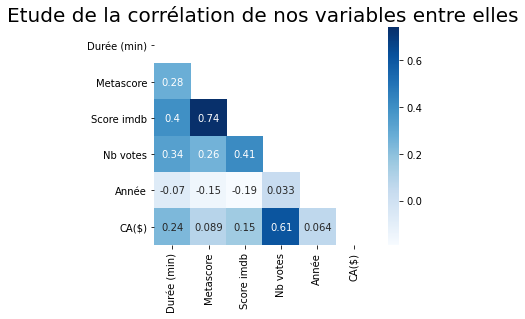

In [13]:
corrMatrice = dfC.corr()
matrice = np.triu(corrMatrice)
sns.heatmap(corrMatrice, annot = True,square = True, mask = matrice, cmap='Blues')
plt.title('Etude de la corrélation de nos variables entre elles', fontsize = 20)
plt.show()

On peut constater que le score en box office (CA($)) est corrélé positivement avec toutes les autres variables y compris l'année bien que cette corrélation soit assez faible. C'est avec le nombre de votes que le chiffre d'affaire est le plus corrélé. On peut interpréter le nombre de votes comme un indice de 'notoriété' puique un nombre de votes élevé nécessite que beaucoup de personne l'ait visionné.

On remarque également que le chiffre d'affaire est plus corrélé aux scores du public qu'aux scores des critiques, mais que les deux variables sont corrélées entre elles aussi ! 

Nous décidons donc d'étudier plus précisément la distribution des notes du public et des critiques et de leurs influences sur le chiffre d'affaire. 

#### Quel lien entre les notes des spectateurs (amateurs) et celles des critiques (professionnels) ?


Text(0.5, 0.98, 'Analyse du lien entre les notes du public et les notes des critques')

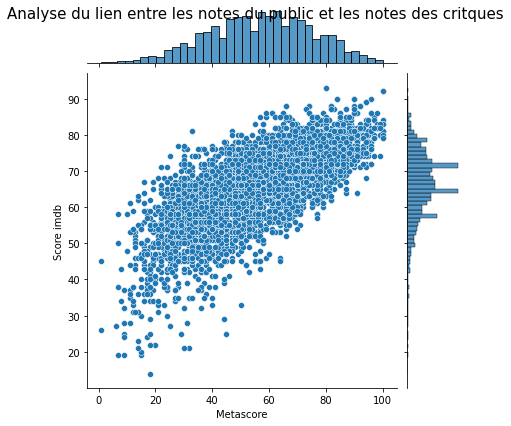

In [14]:
sns.jointplot(data=df, x='Metascore', y='Score imdb')
plt.suptitle('Analyse du lien entre les notes du public et les notes des critques', fontsize=15)

On remarque une assez forte concentration autour d'une droite. On peut déduire de ce graphe qu'il y a une certains cohérence entre l'avis des spectateurs et des critiques. Cependant on remarque qu'en général les spectateurs donnent de meilleures notes que les critiques.

C'est ce que nous allons observer en comparant la distribution de ces notes.

C:\Users\Clara\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Clara\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Score')

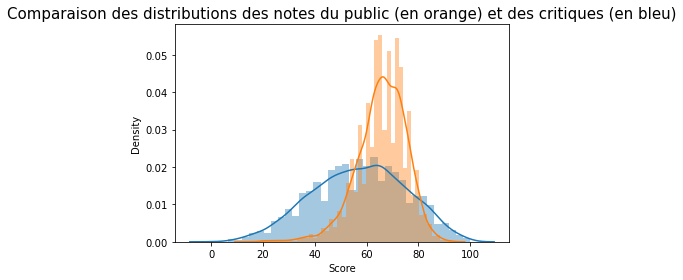

In [15]:
sns.distplot(df.Metascore)
sns.distplot(df['Score imdb'])
plt.title('Comparaison des distributions des notes du public (en orange) et des critiques (en bleu)',fontsize=15)
plt.xlabel('Score')

On réunit sur un même graphe la répartition des notes des spectateurs avec celle des critiques. En bleu se trouve la répartition des notes des critiques et en orange celle des notes des spectateurs.

On retrouve le fait que les spectateurs donnent en moyenne des meilleures notes que les critiques, mais les écarts-types sont bien différents : les notes des spectateurs sont finalement plus semblables entre elles tandis que les avis des critiques semblent plus hétérogènes (les écarts à la moyenne sont en moyenne plus grands).

#### Quel lien peut-on établir entre l'avis du public, celui des critiques et le chiffre d'affaire ?

On peut maintenant essayer de mettre en avant un lien entre le succès d'un film et son chiffre d'affaire. Représentons dans un graphe le succès des films auprès des critiques et leur chiffre d'affaires.

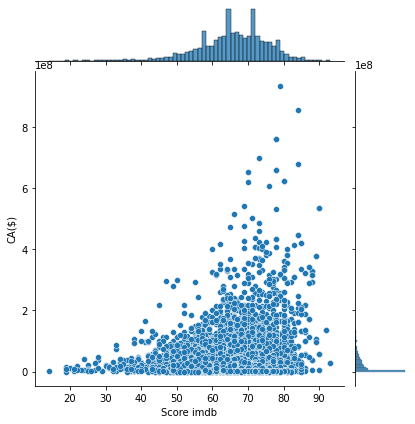

In [16]:
sns.jointplot(data=df, x='Score imdb', y="CA($)")


De manière assez évidente, ce graphe nous montre que les films avec le plus gros chiffres d'affaires ont obtenu de bonnes notes auprès des spectateurs (amateurs). Cela ne nous étonne pas : les plus gros succès du box office sont ceux qui plaisent au public et qui attirent beaucoup de monde dans les salles. De plus la matrice de corrélation nous montrait un indice de corrélation significatif entre le score imdb et le nombre de votes (ie. la notoriété). 

Par ailleurs dans les films bien notés on retrouve tout type de chiffre d'affaire.  

Regardons maintenant ce qu'il se passe quand on s'intéresse à l'avis des critiques (professionnels). 

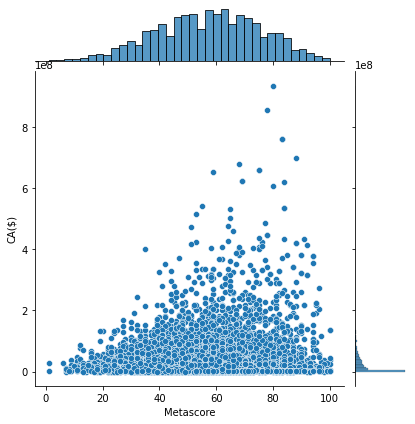

In [17]:
sns.jointplot(data=df, x='Metascore', y="CA($)")

Les résultats sont semblables mais quand on s'intéresse à l'avis des critiques professionnels, le lien entre chiffre d'affaire et note est moins clair. En effet, plus de films avec de gros chiffres d'affaire se retrouvent un peu moins bien notés. Ce résultat est cohérent puisqu'on nous avions observé que les critiques étaient en moyenne plus 'sévère'. 

Ainsi nous pouvons finalement dire que :
- les notes accordées aux films sont en moyenne supérieures à 50/100
- la notoriété d'un film (nombre de votes sur IMDb) est fortement correlée à son chiffre d'affaire et donc également à sa note
- les notes données aux films sont un indice peu pertinent pour deviner le chiffre d'affaire 
- mais un gros chiffre d'affaire indique significativement une bonne note auprès à la fois du public et des critiques

**Finalement, un film en haut du box office (ie. générant un gros chiffre d'affaire) sera un film massivement noté sur IMDb et généralement plus apprécié par les spectateurs que par les critiques.**

Nous allons maintenant nous pencher sur la répartition dans le temps des films que nous étudions. 

### Comment se répartissent les films de notre base de donnée en fonction de leur date de sortie ?

In [18]:
df['Décennie'] = df['Année'].apply(lambda x:((x)//10)*10)
DF_Decennies = df.groupby('Décennie').count()
DF_Decennies['Film']

<ipython-input-18-b99d5464a17d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Décennie'] = df['Année'].apply(lambda x:((x)//10)*10)


Décennie
1950      55
1960     106
1970     238
1980     687
1990    1076
2000    2255
2010    2283
2020       8
Name: Film, dtype: int64

<ipython-input-19-29e7106bd1f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Décennie'] = df['Année'].apply(lambda x:((x-1900)//10)*10)
<ipython-input-19-29e7106bd1f7>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Décennie'] = df['Année'].apply(lambda x:((x)//10)*10)


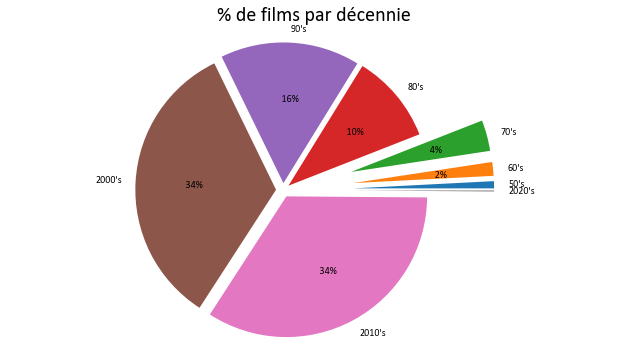

In [19]:
df['Décennie'] = df['Année'].apply(lambda x:((x-1900)//10)*10)
def Stat(gr):
    return {'min':gr.min(),'max':gr.max(),'nombre': gr.count(),'moyenne':gr.mean()}

test = df['Année'].groupby(df['Décennie']).apply(Stat).unstack()

def Label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine

plt.rc('font', weight='medium', family='Calibri')
f, ax = plt.subplots(figsize=(11, 6))
labels = [Label(s) for s in  test.index]
sizes  = test['nombre'].values
explode = [0.5 if sizes[i] < 400 else 0.05 for i in range(8)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:4.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% de films par décennie',color='k', fontsize=20);
df['Décennie'] = df['Année'].apply(lambda x:((x)//10)*10)

Nous remarquons ici que parmi les films que nous allons étudier, la majorité est sortie entre 1990 et 2019. Nous n'avons que peu de film pour les années 50, 60 et 70. Cela peut s'expliquer par l'augmentation de la production cinématographique dans la deuxième moitié du XXe mais cette explication n'est pas suffisante. 

**Le site ayant été créé en 1990** et l'accès à internet ayant été démocratisé dans cette décennie également, il parait logique de retrouver majoritairement des films à partir de cette période. De plus, les films antérieurs à cette date sont dans notre base des films ayant suffisament de nombre de votes pour y figurer et donc des films plus connus et mieux réputés auprès public pour qu'ils aient choisi de le regarder des dizaines d'années après leurs sorties. En effet, un film mal réputé qui aurait généré un chiffre d'affaire peu élevé l'année de sa sortie aura plus de mal a traversé les années pour être encore visionné des années plus tard. **Cela peut constituer un biais dans notre base.**

In [20]:
df.groupby('Décennie').mean()

,Année,Durée (min),Metascore,Score imdb,Nb votes,CA($)
Décennie,,,,,,
1950,1955.145455,116.072727,83.363636,77.618182,98963.818182,1.754499e+07
1960,1964.801887,126.198113,76.311321,75.584906,85184.103774,2.641315e+07
1970,1974.676471,113.558824,68.596639,71.764706,103513.899160,3.624255e+07
1980,1985.213974,107.318777,57.326055,66.944687,72981.621543,3.670538e+07
1990,1995.210037,110.667286,56.981413,66.556691,126311.573420,4.454848e+07
2000,2004.800887,107.721064,54.084701,64.552993,113488.133481,4.097057e+07
2010,2014.105563,108.763031,57.366185,65.171704,114515.389400,4.685364e+07
2020,2020.000000,113.625000,55.125000,67.125000,109717.625000,9.452360e+07


Lorsque l'on s'intéresse à la colonne score IMDb, celle-ci nous confirme que les films des années 1950 à 1970 présents dans notre base sont bien des films à succès qui plaisent au public qui ont donc su traversé les années. 

Nous sommes donc conscientes de ce biais. En conséquence, nous remettrons nos futures analyses en perspective si besoin.


### Analyse de l'évolution du chiffre d'affaire en fonction du temps 
Maintenant que nous comprenons mieux notre base et les variables que nous étudions, analysons l'évolution du box office américain.

Text(0.5, 1.0, 'Evolution du box office américain de 1950 à nos jours')

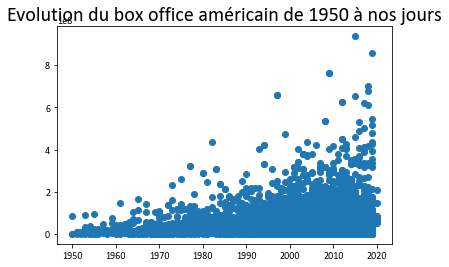

In [21]:
plt.scatter(x=df['Année'], y=df['CA($)'])
plt.title("Evolution du box office américain de 1950 à nos jours", fontsize=20)

Il semble ici y avoir une augmentation du chiffre d'affaire moyen et également des plus gros chiffres d'affaire, soit une tendance générale à la hausse du box office américain.

**Etudions l'évolution moyenne par année.**

Text(0.5, 1.0, "Evolution du chiffre d'affaire moyen entre 1950 et 2020")

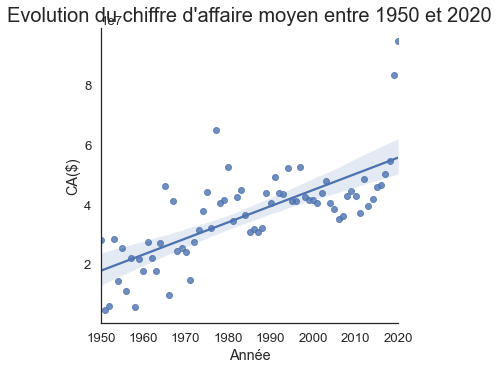

In [22]:
CA_moyen = df.groupby('Année').mean()
CA_moyen = CA_moyen.reset_index()
sns.set(font_scale=1.2,style="white")
sns.lmplot(x='Année', y='CA($)', data=CA_moyen, palette="red_r")
plt.title("Evolution du chiffre d'affaire moyen entre 1950 et 2020", fontsize=20)




Cette projection confirme la tendance claire à l'augmentation du chiffre d'affaire par an. Cependant, les deux derniers points semblent anormalement haut. Ils correspondent au moyenne du chiffre d'affaire pour les années 2019 et 2020.

In [23]:
films_récents = df[df.Année >= 2019]
films_récents.sort_values(by = 'CA($)')

,Film,Année,Genre,Réalisateur,Durée (min),Metascore,Score imdb,Nb votes,CA($),Décennie
6715,The Hole in the Ground,2019,"Drama, Horror, Mystery",Lee Cronin,90,63,57,15362,21072.0,2010
8444,Can You Keep a Secret?,2019,"Comedy, Romance",Elise Duran,94,35,53,9983,26785.0,2010
8735,Triple Threat,2019,"Action, Thriller",Jesse V. Johnson,96,60,56,9398,76289.0,2010
6739,Brittany Runs a Marathon,2019,"Comedy, Drama",Paul Downs Colaizzo,104,72,68,15267,223187.0,2010
560,Jojo Rabbit,2019,"Comedy, Drama, War",Taika Waititi,108,58,79,282550,349555.0,2010
...,...,...,...,...,...,...,...,...,...,...
918,Toy Story 4,2019,"Animation, Adventure, Comedy",Josh Cooley,100,84,78,197060,434038008.0,2010
1426,La Reine des Neiges 2,2019,"Animation, Adventure, Comedy","Chris Buck, Jennifer Lee",103,64,69,131216,477373578.0,2010
389,Star Wars: L'Ascension de Skywalker,2019,"Action, Adventure, Fantasy",J.J. Abrams,141,53,66,361840,515202542.0,2010
862,Le Roi Lion,2019,"Animation, Adventure, Drama",Jon Favreau,118,55,69,206462,543638043.0,2010


Nous comprenons que **les films sortis en 2019 et 2020 biaisent nos données** puisque nous n'avons pas assez de recul et d'informations dessus. Pour 2020, ce problème est évidemment exarcerbé par le fait que l'année n'est pas terminée et que la situation sanitaire a énormément restreint l'activité cinématographique. Sur ces deux années, cela représente 127 films ce qui est peu.

**Nous décidons donc de supprimer ces films de la base.**

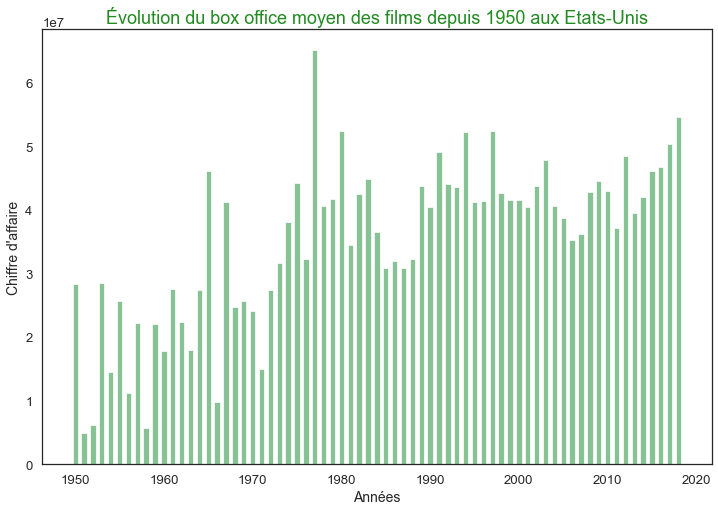

In [24]:
df_1950_2018 = df[df.Année<2019]
annee=df_1950_2018.groupby('Année').count()[['CA($)']].index.tolist()
figures=df_1950_2018.groupby('Année')['CA($)'].mean().tolist()
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

bar_width = 0.6
opacity = 0.7

rects = ax.bar(annee, figures, bar_width,
                alpha=opacity,align='center', color='g')

ax.set_xlabel('Années', fontsize = 14)
ax.set_ylabel('Chiffre d\'affaire', fontsize = 14)
ax.set_title('Évolution du box office moyen des films depuis 1950 aux Etats-Unis',fontsize=18, color='forestgreen')
plt.show()

Nous allons tenter d'expliquer plus précisément l'augmentation du chiffre d'affaires annuel dans la prochaine partie, mais vérifions d'abord ce que nous otenons en l'expliquant simplement par l'année de sortie. Pour cela procédons à une **régression linéaire.**

In [25]:
df_reg = df_1950_2018.groupby('Année').mean()
df_reg = df_reg.reset_index()
y=(df_reg['CA($)'])
X=df_reg['Année']
X=sm.add_constant(X)
model = sm.OLS(y.astype(float),X.astype(int))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  CA($)   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     68.51
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           7.62e-12
Time:                        22:00:54   Log-Likelihood:                -1202.0
No. Observations:                  69   AIC:                             2408.
Df Residuals:                      67   BIC:                             2413.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.614e+08   1.08e+08     -7.950      0.0

Finalement nous obtenons bien un **coefficient positif** dans notre regression avec un **R-squared assez élevé** étant donné l'unique variable explicative utilisée et une **p_value nulle**, confirmant la croissance certaine des recettes chaque année dans l'industrie cinématographique.

cependant, il est clair que l'année de sortie n'est évidemment pas une explication suffisante pour expliquer la croissance du chiffre d'affaire.

**Afin d'expliquer cette croissance par des facteurs socio-économiques, nous allons nous intéresser au cas français, pour lequel nous avons récolter des données plus précises quant à la fréquentation et à la répartition des types de spectateurs.**

# Deuxième partie : Afin de mieux comprendre l'évolution de l'industrie cinématographique et de son économie nous allons nous intéresser à l'exemple français. 


Nous avons vu que le box office aux Etats-Unis a augmenté entre 1950 et 2018. Le box office se calculant comme la somme des recettes au guichet pour un film donné, nous allons voir si nous retrouvons ce résultat à l'échelle agrégée en France, en considérant la somme des recettes au guichet des cinémas français par an. **Nous essayerons ensuite d'expliquer l'évolution des recettes avec les données du CNC : une augmentation des box-offices est-elle nécessairement liée à une augmentation de la fréquentation des cinémas ?**

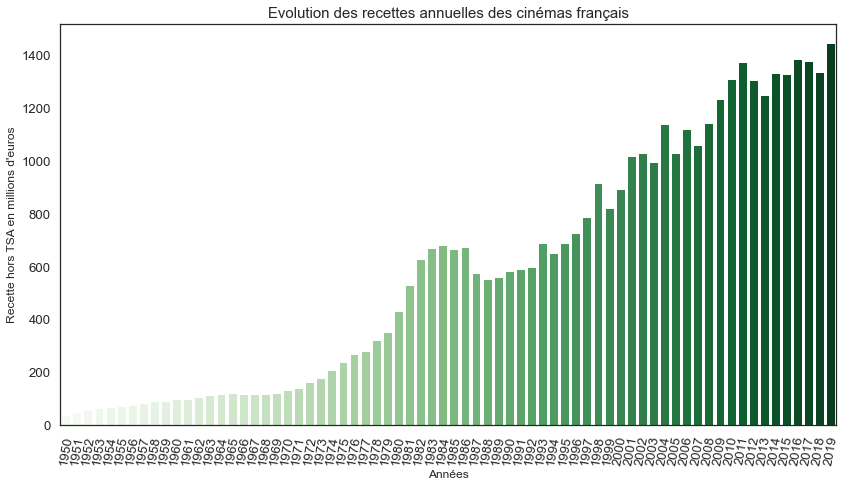

In [26]:
plt.figure(figsize = (12,7))
sns.barplot(x = DF_entrées['Année'],y =DF_entrées['Recette hors TSA (M€ courants)'],palette='Greens')
plt.xlabel('Années', fontsize = 12)
plt.ylabel('Recette hors TSA en millions d\'euros', fontsize = 12)
plt.title('Evolution des recettes annuelles des cinémas français', fontsize = 15)
plt.xticks(rotation = 80)
plt.tight_layout()

Nous constatons ici une augmentation nette des recettes annuelles des cinéma au cours entre 1950 et 2018 en France. Cela concorde tout à fait avec l'augmentation du box office moyen constaté aux Etats-Unis.
**Alors, comment expliquer cette hausse ?**

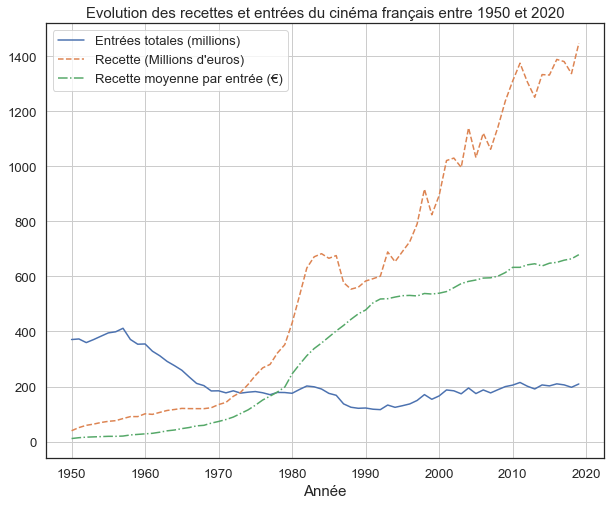

In [27]:
fig = plt.figure(figsize=(10,8))

DF_graphe = DF_entrées.set_index('Année')

ax1 = plt.subplot(1,1,1)
#On plotte sur le même graphe la plupart des caractéristiques de notre jeu de données
ax1 = plt.plot(DF_graphe['Entrées totales (millions)'], marker='', linestyle ='solid', label='Entrées totales (millions)')
ax1 = plt.plot(DF_graphe['Recette hors TSA (M€ courants)'], marker='', linestyle ='--', label="Recette (Millions d'euros)")
ax1 = plt.plot(DF_graphe['Recette moyenne par entrée (€)']*100, marker='', linestyle ='-.', label='Recette moyenne par entrée (€)')



plt.grid('y')

plt.xlabel("Année", fontsize = 15)
#plt.ylabel("", fontsize = 15)
plt.legend(loc='best')
plt.title("Evolution des recettes et entrées du cinéma français entre 1950 et 2020", fontsize=15)
plt.show()

La première conclusion que nous pouvons tirer de ce graphe est que l'augmentation des recettes du cinéma français par an ne s'explique pas par une augmentation de la fréquentation des cinémas, mais par une augmentation du prix du billet pour une séance, ici visible à travers l'évolution de la courbe `Recette moyenne par entrée`.

Au contraire, une baisse nette de la fréquentation des cinéma est visible avec la baisse de la courbe `Entrées totales (millions)`.

Entre les années 1950 et 2020, ce nombre a été divisé par deux. La baissse la plus forte a lieu entre les années 1950 et 1990. 

**On peut être tenté d'expliquer cette baisse de la fréquentation par la démocratisation de la télévision et par la hausse du prix du billet en supposant une élasticité-prix négative.**

Cependant, le nombre d'entrée se met à augmenter doucement à partir des années 1990 alors que le prix du billet continu a nettement augmenter. De plus, l'apparition du streaming dans les années 2000 ne semble pas contrarier cette hausse.

L'effet de l'augmentation du prix du billet semble donc avoir un effet relativement faible sur la fréquentation des cinémas. 

### Etudions de plus près l'effet de la hausse du prix du billet sur le public

In [28]:
y= DF_entrées['Entrées totales (millions)']
X=DF_entrées['Recette moyenne par entrée (€)']
X=sm.add_constant(X)
model = sm.OLS(y.astype(float),X.astype(int))
results = model.fit()
print(results.summary())

                                OLS Regression Results                                
Dep. Variable:     Entrées totales (millions)   R-squared:                       0.372
Model:                                    OLS   Adj. R-squared:                  0.363
Method:                         Least Squares   F-statistic:                     40.28
Date:                        Tue, 15 Dec 2020   Prob (F-statistic):           2.09e-08
Time:                                22:00:57   Log-Likelihood:                -389.76
No. Observations:                          70   AIC:                             783.5
Df Residuals:                              68   BIC:                             788.0
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

#### Nous étudions d'abord la hausse du prix du billet sur l'ensemble des spectateurs.

Cette regression linéaire montre que, toutes choses égales par ailleurs, si par rapport à une année donnée le billet est plus cher en moyenne d'un euros, on peut prédire qu'il y aura environ 20 millions d'entrées en moins. On trouve bien un **coefficient négatif**, ce que nous attendions. Le coefficient est significatif mais le R^2 est relativement faible 0,362. 

**Cela semble cohérent : des prix de billets plus élevés sont corrélés à une demande de tickets plus faible mais les prix des billets sont loin d'expliquer entièrement les variations de la demande comme nous le signale le R^2.**

#### Etudions maintenant l'impact de la hausse du prix sur les différentes classes socio-professionnelles.

Afin de comprendre la croissance du nombre d'entrée à partir des années 1990 malgré l'augmentation du prix du billet nous pouvons nous pencher sur l'effet différencié d'une augmentation du prix d'un billet en fonction de la classe socio-professionnelle : peut-être que les individus faisant parti des 'CSP +' sont mois sensibles à une augmentation du prix du billet que les autres par exemple. Ci-dessous, la décomposition des différentes classes socio-professionnelles.


In [29]:
DF_CSP.head()

,Année,CSP +,dont : cadres,prof. intermédiaires,CSP -,dont : agriculteurs,employés,ouvriers,inactifs,dont : retraités,"élèves, étudiants",total
1,1993,5.7,6.7,5.3,3.5,1.8,3.8,3.2,4.6,3.3,5,4.6
2,1994,4.2,4.9,3.7,2.2,1.7,2.7,1.7,3.5,2.1,3.9,3.3
3,1995,5.3,6.3,5.1,3.4,1.3,3.6,3.2,4.4,3.2,4.9,4.4
4,1996,6,7.1,5.7,3.5,1.8,3.8,3.1,4.6,4.3,4.7,4.6
5,1997,6.8,8.4,6,3.2,2.8,3.5,2.8,4.8,3.5,5.2,4.8


In [30]:
DF_entrées_1993_2015 = DF_entrées[DF_entrées['Année']>=1993]
DF_entrées_1993_2015 = DF_entrées_1993_2015[DF_entrées_1993_2015['Année']<=2015]
DF_entrées_1993_2015=DF_entrées_1993_2015.reset_index()
DF_entrées_1993_2015=DF_entrées_1993_2015.drop('index',axis=1)


#### Représentons graphiquement ces évolutions en fonction de la hausse du prix du billet.

<function matplotlib.pyplot.show(close=None, block=None)>

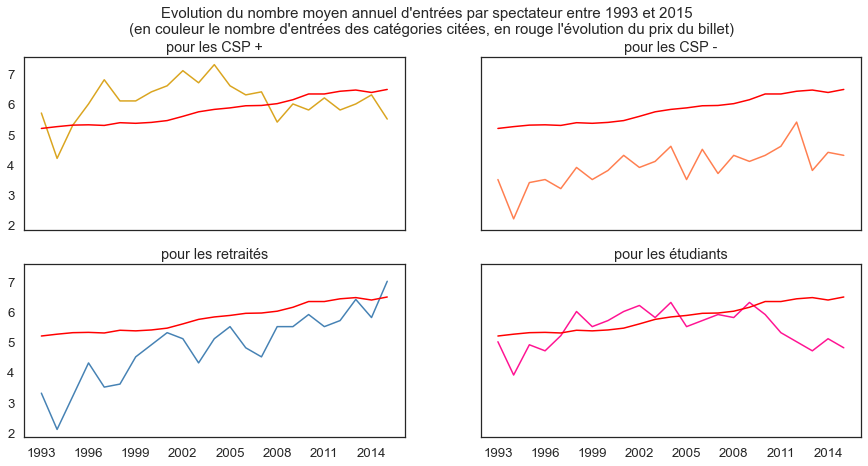

In [31]:
DF_CSP['Année'] = DF_CSP['Année'].astype(int)
f, axs = plt.subplots(2,2, sharey = True, sharex = True, figsize=(15,7) )
x = DF_CSP['Année']
y = DF_CSP['CSP +']
z = DF_CSP['CSP -']
w = DF_CSP['dont : retraités']
f = DF_CSP['élèves, étudiants'] 
a = DF_entrées_1993_2015['Recette moyenne par entrée (€)']
plt.suptitle("Evolution du nombre moyen annuel d\'entrées par spectateur entre 1993 et 2015 \n (en couleur le nombre d'entrées des catégories citées, en rouge l'évolution du prix du billet)", fontsize = 15)
axs[0,0].plot(x,y, color = 'goldenrod')
axs[0,0].plot(x,a, color = 'red')
axs[0,0].set_title('pour les CSP +')
axs[0,1].plot(x,z, color = 'coral')
axs[0,1].plot(x,a, color = 'red')
axs[0,1].set_title('pour les CSP -')
axs[1,0].plot(x,w, color = 'steelblue')
axs[1,0].plot(x,a, color = 'red')
axs[1,0].set_title('pour les retraités')
axs[1,1].plot(x,f, color = 'deeppink')
axs[1,1].plot(x,a, color = 'red')
axs[1,1].set_title('pour les étudiants')
plt.xticks(np.arange(min(x),max(x), 3.0))
fig.tight_layout()
plt.show

Le premier constat que nous pouvons faire est que les 'CSP -' regroupant agriculteurs, employés, ouvriers, inactif vont en moyenne moins de fois au cinéma par an que les 'CSP +' regroupant cadres et professions intermédiaires. 

**Il semble donc exister un facteur économique expliquant en partie l'intensité de la fréquentation du cinéma.**

Cependant, si le nombre annuel d'entrée moyen par an n'est par surprenant pour les CSP + et les CSP -, ce qui l'est beaucoup plus c'est leur fluctuation. En effet, La hausse du prix du billet de cinéma ne semble pas jouer sur ce nombre. Plus surprenant encore : le nombre annuel d'entrée moyen par an augmente pour les CSP -.

Nous pensions que la classe socio-professionnel permettrait de différencier des publics ayant une sensibilité au prix différente mais il semble que le plus discriminant soit en réalité la classe d'age : la fréquentation du cinéma par les retraité semble complétement insensible à la hausse du prix du billet et continue depuis les années 1990 a croitre fortement. Au contraire, les étudiants semblent constituer la catégorie la plus sensible à l'évolution du prix du billet.

**Afin de confirmer cette observation nous pouvons faire des régressions linéaires simples du nombre annuel d'entrée moyen par an sur le prix et comparer les coefficients en fonction des tranches d'age.**

In [32]:
y=DF_age[['entre 20 et 29 ans']]
X=DF_age[['Recette moyenne par entrée (€)']]
X=sm.add_constant(X)
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

y=DF_age[['40 ans et plus']]
X=DF_age[['Recette moyenne par entrée (€)']]
X=sm.add_constant(X)
model = sm.OLS(y.astype(float), X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     entre 20 et 29 ans   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     14.43
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           0.000789
Time:                        22:00:58   Log-Likelihood:                -28.235
No. Observations:                  28   AIC:                             60.47
Df Residuals:                      26   BIC:                             63.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

**Les résultats de ces régressions linéaires nous confirment que la sensibilité au prix du billet de cinéma dépend de l'age** :

Pour les 20-29 ans, nous obtenons un coefficient négatif d'environ -0,95. Ce coefficient est significatif et nous obtenons un R<sup>2</sup> de 0,357. Des prix de billets élevés sont donc corrélés à une fréquentation moyenne plus faible pour les 20-29 ans, et leur assuidité au cinéma est en partie expliquée par le prix du billet. Pour les 40 ans et plus, le prix n'explique que très peu le nombre d'entrée par an : le R<sup>2</sup> est très faible (0,153) et le coefficient et méme positif. 

Il semble donc bien que les variation du prix des billets de cinéma n'influence par la demande des différentes classes d'age de la même manière. 

Le fait que l'élasticité-prix ne soit pas négative pour toute les tranches d'age n'est pas si surprenant. 

L'achat d'une place de cinéma a une dimension culturelle forte qui ne permet pas de l'assimiler à l'achat d'un bien ordinaire. En revanche ce qui est intéressant c'est que l'élasticité-prix est négative pour les 'jeunes', en particulier pour les 20-29 ans. 

**On peut se demander si cela peut être lié au streaming.** Les jeunes fréquentent peut-être plus des sites de visionnage et de téléchargement de films ce qui leur procure un substitut au cinéma, ce dont les autres classes d'age disposent moins s'ils sont moins habitués à ces pratiques. 

#### Regardons donc les chiffres du streaming d'un peu plus près

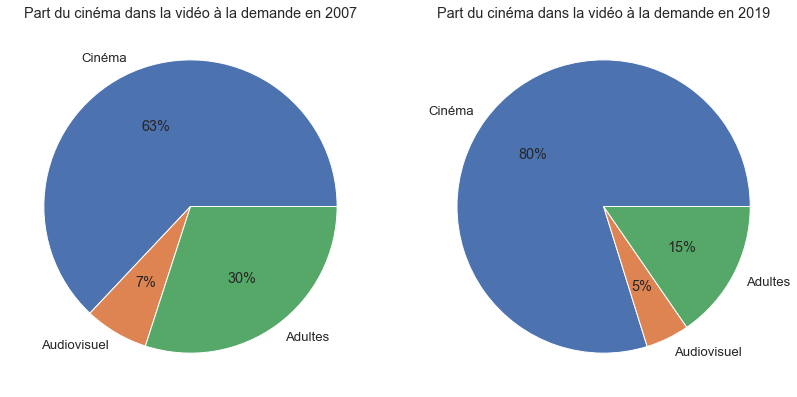

In [33]:
# En 2007 :  
f, axs = plt.subplots(1,2)
L_2007_ = [conso_vad_Genre.iloc[0,i] for i in range(1,4)]
axs[0].pie(L_2007_, labels = ['Cinéma', 'Audiovisuel', 'Adultes'], autopct = '%.0f%%')
axs[0].set_title('Part du cinéma dans la vidéo à la demande en 2007')

# En 2019
L_2019_ = [conso_vad_Genre.iloc[12,i] for i in range(1,4)]
axs[1].pie(L_2019_, labels = ['Cinéma', 'Audiovisuel', 'Adultes'], autopct = '%.0f%%')
axs[1].set_title('Part du cinéma dans la vidéo à la demande en 2019')
plt.tight_layout(rect = [0,0,2,2])
plt.show()

Les bases de données du CNC nous permettent d'avoir accès aux chiffres du streaming payant en France.

Le premier constat que l'on peut faire c'est que la part du cinéma dans la vidéo à la demande a augmenté entre 2007 et 2019. On a donc, aujourd'hui, un usage des vidéos à la demande qui est de plus en plus orienté vers le visionnage de films cinématographiques. Comme nous l'avions vu il n'y a cependant pas de baisse de la fréquentation du cinéma sur cette période.

**Il ne semble donc pas avoir d'effet direct et prépondérant de l'augmentation de visionnage de films en streaming sur la fréquentation des salles de cinéma.**

**Mais qui sont les utilisateurs principaux des plateformes de téléchargment et de visionnage ?**

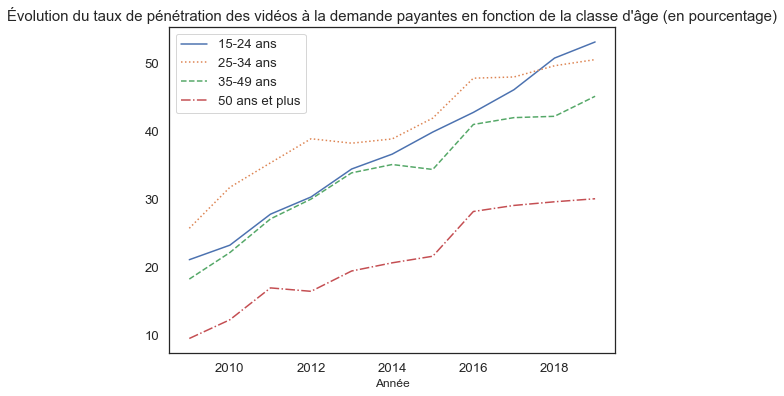

In [34]:
# Évolution selon la classe d'âge

fig = plt.figure(figsize=(8,6))

x = [ i for i in range(2009,2020) ]

data_achat_15_24 = [achat_profil.iloc[i, 4] for i in range(0,11)] 
data_achat_25_34 = [achat_profil.iloc[i, 5] for i in range(0,11)] 
data_achat_35_49 = [achat_profil.iloc[i, 6] for i in range(0,11)] 
data_achat_50_plus = [achat_profil.iloc[i, 7] for i in range(0,11)] 


plt.plot(x,data_achat_15_24, label="15-24 ans", linestyle ='solid') 
plt.plot(x,data_achat_25_34, label="25-34 ans", linestyle = ':') 
plt.plot(x,data_achat_35_49, label="35-49 ans", linestyle = '--')
plt.plot(x,data_achat_50_plus, label="50 ans et plus", linestyle = '-.')  
plt.legend()
plt.title('Évolution du taux de pénétration des vidéos à la demande payantes en fonction de la classe d\'âge (en pourcentage)', fontsize = 15)
plt.xlabel("Année", fontsize = 12)
plt.show() 

Les résultats sont assez nets : les 15-34 ans sont les plus grands consommateurs de vidéo à la demande, le taux de pénétration a aujourd'hui dépassé 50% concernant cette tranche d'age. Bien que le taux de pénétration ait nettement augmenté chez les plus de 50 ans, il reste relativement faible et ne dépasse pas les 30%. On peut donc raisonnablement penser que le visionnage de vidéos à la demande soit une alternative plausible pour les jeunes à la fréquentation du cinéma alors qu'elles le soit moins pour les personnes plus agées.

**Nous avons appris beaucoup de choses sur l'économie du cinéma :**

* Depuis les années 1950, les recettes des cinémas français ne cessent d'augmenter notamment en raison d'une augmentation du prix du billet d'entrée.
* Si cette augmentation du prix du billet permet une telle augmentation des recettes, c'est parce que la fréquentation des cinémas ne subit pas une baisse systématique en fonction de ce prix croissant, au contraire, elle augmente même à partir des années 1990.
* Cela peut s'expliquer si l'on découpe le public en tranche d'age : tous n'ont pas une élasticité-prix négative ce qui permet de conserver du public, notamment les enfants et les plus âgés.
* Ceux étant le plus sensible à une augmentation du prix du billet, ce sont les jeunes. On peut suggérer que cette sensibilité vienne en partie de leur fréquentation des sites de visionnage et de téléchargement de films en ligne. Cela leur offre une alternative à la 'sortie ciné' quand celle-ci devient trop coûteuse.

**Cependant, rien ne nous permet d'expliquer la hausse des années 1990.**

**Regardons alors pour finir la diversité de l'offre cinématographique : peut-être que c'est cette diversité qui attire aujourd'hui le public au cinéma.**

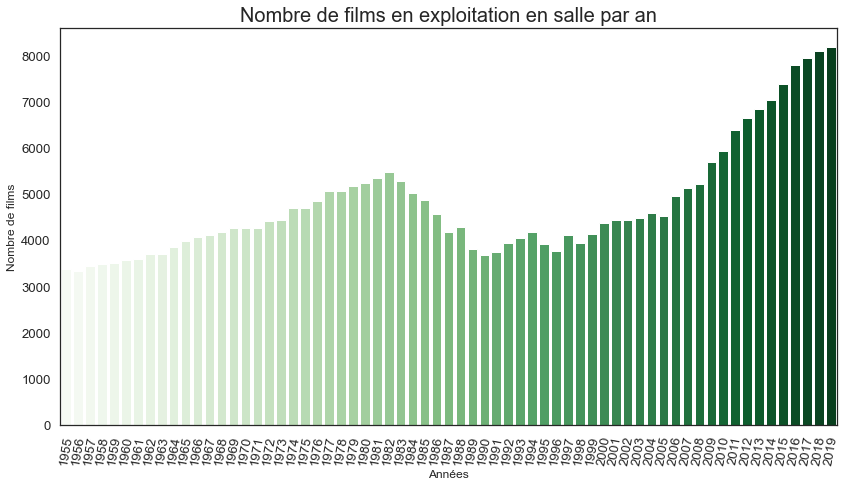

In [35]:
plt.figure(figsize = (12,7))
sns.barplot(x = nb_films_france['Année'],y =nb_films_france['Nombre de films'],palette='Greens')
plt.xlabel('Années', fontsize = 12)
plt.ylabel('Nombre de films', fontsize = 12)
plt.title('Nombre de films en exploitation en salle par an', fontsize = 20)
plt.xticks(rotation = 80)
plt.tight_layout()

Nous utilisons ici une nouvelle base de données du CNC à propos du nombre de films en exploitation en salle par an de 1955 à 2019. Les films 'en exploitation' sont ceux ayant été projeté au moins une fois. On voit ici que l'offre cinématographique se diverisifie à partir des années 1990. On peut peut-être supposer que cette augmentation de l'offre a permis en partie la relance de la fréquentation des cinémas. 

**L'offre étant plus diverse il est possible que le public soit également plus divers et plus nombreux.**

# Troisième partie : comment définir les films à succès ?

Nous avons précédemment constaté que le chiffre d’affaire des cinéma français ont augmenté de 1950 à 2020 et que la fréquentation à globalement baissée durant cette même période. Si nous avons tenté d’expliquer ces tendances globale une chose reste inexpliquée : la grande variabilité annuelle de ces variables. On constate par exemples des pics de fréquentation en 1985 et en 2010. Comment l’expliquer ? Notre première intuition est que d’une année sur l’autre, la fréquentation des cinémas peut augmenter brusquement à la sortie de blockbusters, de films attendus, ou de têtes d’affiche. Mais alors quelles sont les caractéristiques de ces films qui attirent un public aussi important aujourd’hui ?

In [36]:
len(df.Genre.unique()) # Nombre de 'combinaisons' de genre 

374

Afin d'étudier les genres de film les plus représentés, nous commençons par regarder sous quelle forme sont décrits ces genres.


Nous remarquons alors que nous allons devoir modifier notre dataframe. En effet les genres sont regroupés sous 390 combinaisons de genres. Notre but est alors de décrire chaque film selon s'il appartient à une grande catégorie de genre ou non. Nous pourrons alors étudier les genres un par un.  

Pour ce faire, la méthode la plus pertinente nous semble être du One Hot Encoding. Cette méthode va nous permettre de créer de nouvelles variables binaires. Cela facilitera nos analyses puisque en utilisant de simples sommes, nous obtiendrons des statistiques intéressantes sur chaque grande catégorie cinématographique. 

Après une observation de nos données, nous créons une liste de 15 genres (liste 'Mots') que nous allons pouvoir étudier. Nous rajoutons une catégorie 'Indéfini' afin d'y classer les films qui ne sont pas représentés sous les genres que nous avons choisis. Nous espérons cependant que la catégorie 'Indéfini' ne contiendra aucun film. 

In [37]:
#Choix des familles de genre
Mots = ['Drama', 'Comedy','Action','Thriller','Adventure','Biography','Sci-Fi','Fantasy','History','Animation','Crime','War','Mystery','Family','Romance']

Pour procéder au **One Hot Encoding**, nous allons utiliser des techniques de NLP. En effet il s'agit ici de répérer dans chaque liste de mots les mots qui la composent. 

Ainsi pour chaque genre que nous voulons étudier, nous observons pour chaque film si le genre choisi appartient à sa liste de genres. Si oui, la variable associée prend la valeur 1, sinon elle prend la valeur 0. 

Nous regroupons ces boucles sous la fonction `one_hot_genre` construite ci-dessous.



In [38]:
#Création d'une fonction repérant l'appartenance d'un film à un ou plusieurs genres
def one_hot_genre (df, mots):
    
    A = df.copy()
    
    # Crée de nouvelles colonnes qui serviront pour le 1 hot encoding des genres
    for mot in mots:
        A[mot] = 0 # Initilise à 0 pour tous les genres
    A['Indéfini'] = 0
        
    # On parcourt ensuite les lignes du dataframe et on vérifie la présence de chaque genre 
    
    for index, genre in enumerate(A.Genre):
    
        indefini = True
        if type(genre) == str :
            for mot in mots :
                if mot in genre :
                    indefini = False
                    A.loc[index, mot] = 1
        elif indefini :
            A.loc[index, 'Indéfini'] = 1
    
    return A

Appliquons maintenant cette fonction à notre dataframe et donc à tous les films que nous étudions. La fonction va agrandir notre dataframe en créant une nouvelle colonne pour chaque nouvelle variable.

In [39]:
#On applique cette fonction à notre dataframe

df_Genre_oneHot=one_hot_genre(df, Mots).dropna().drop('Indéfini',axis=1)
df_Genre_oneHot

,Film,Année,Genre,Réalisateur,Durée (min),Metascore,Score imdb,Nb votes,CA($),Décennie,...,Biography,Sci-Fi,Fantasy,History,Animation,Crime,War,Mystery,Family,Romance
0,Les évadés,1994.0,Drama,Frank Darabont,142.0,80.0,93.0,2316795.0,28341469.0,1990.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Dark Knight: Le chevalier noir,2008.0,"Action, Crime, Drama",Christopher Nolan,152.0,84.0,90.0,2279150.0,534858444.0,2000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Inception,2010.0,"Action, Adventure, Sci-Fi",Christopher Nolan,148.0,74.0,88.0,2042137.0,292576195.0,2010.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Fight Club,1999.0,Drama,David Fincher,139.0,66.0,88.0,1835432.0,37030102.0,1990.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Pulp Fiction,1994.0,"Crime, Drama",Quentin Tarantino,154.0,94.0,89.0,1807662.0,107928762.0,1990.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10045,Braveheart,1995.0,"Biography, Drama, History",Mel Gibson,178.0,68.0,83.0,952014.0,75600000.0,1990.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10046,Le Monde de Nemo,2003.0,"Animation, Adventure, Comedy","Andrew Stanton, Lee Unkrich",100.0,90.0,81.0,940715.0,380843261.0,2000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10047,Le Retour du Jedi,1983.0,"Action, Adventure, Fantasy",Richard Marquand,131.0,58.0,83.0,940642.0,309125409.0,1980.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10048,The Lion King,1994.0,"Animation, Adventure, Drama","Roger Allers, Rob Minkoff",88.0,88.0,85.0,931871.0,422783777.0,1990.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nous pouvons maintenant observer le nombre de films dans chaque catégorie en observant simplement les nouvelles variables créées par la fonction. 

Pour ce faire il nous suffit de sommer les lignes. **Nous allons observer les genres les plus représentés.**

**Remarque** : la somme totale ne sera pas égale au nombre total de films puisque chaque film est décrit par plusieurs genres. C'est tout l'intérêt du One Hot Encoding que de conserver cette finesse dans la description. 

In [40]:
Genre_films = df_Genre_oneHot[(Mots)]

s=Genre_films.sum(axis = 0, skipna = True)
s = s.sort_values(ascending = False)
s

Drama        2891.0
Comedy       2041.0
Action       1353.0
Crime        1058.0
Adventure    1058.0
Romance       925.0
Thriller      872.0
Mystery       485.0
Fantasy       462.0
Sci-Fi        431.0
Biography     392.0
Family        322.0
Animation     272.0
History       165.0
War            88.0
dtype: float64

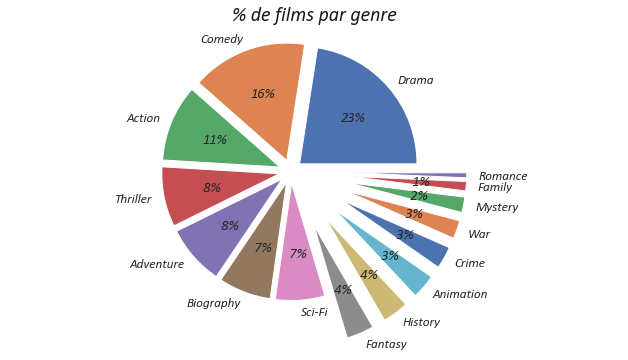

In [41]:
plt.rc('font', weight='medium', family='Calibri', style='oblique')


labels=Mots
f, ax = plt.subplots(figsize=(11, 6))
explode= [0.5 if s[i] < 600 else 0.1 for i in range(15)]
ax.pie(s, explode=explode, labels=labels,
       autopct = lambda x:'{:2.0f}%'.format(x) if x > 1 else '',
       shadow=False)
ax.axis('equal')
ax.set_title('% de films par genre',color='k', fontsize=20);

Nous obtenons ici la répartition des différents genre dans notre base de données. Nous avons ensuite regardé dans les cellules suivantes quels genres avaient généré le plus gros chiffre d'affaire sur l'ensemble de notre base de données. 

In [42]:
df_genre = df_Genre_oneHot.set_index('Film')
df_genre = df_genre.melt(id_vars= ['CA($)','Année','Metascore','Score imdb'], value_vars=Mots)
df_genre=df_genre[df_genre.value==1.0].set_index('variable').drop(['value','Année'],axis=1)
df_genre=df_genre.groupby('variable').mean()
df_genre=df_genre.reset_index()
df_genre=df_genre.sort_values(by='CA($)',ascending=False).reset_index().drop('index',axis=1)
df_genre

,variable,CA($),Metascore,Score imdb
0,Adventure,8.504851e+07,58.821361,67.755198
1,Sci-Fi,8.450055e+07,60.020882,68.819026
2,Action,7.242313e+07,58.412417,67.587583
3,Animation,6.916080e+07,60.720588,67.966912
4,Fantasy,6.824226e+07,57.584416,66.735931
5,Family,5.395782e+07,56.829193,65.487578
6,Thriller,4.721354e+07,57.918578,66.644495
7,Comedy,4.294816e+07,56.561489,65.756492
8,Mystery,4.258628e+07,57.026804,66.375258
9,War,4.042666e+07,61.500000,67.784091


Représentons ceci dans un graphique plus lisible.

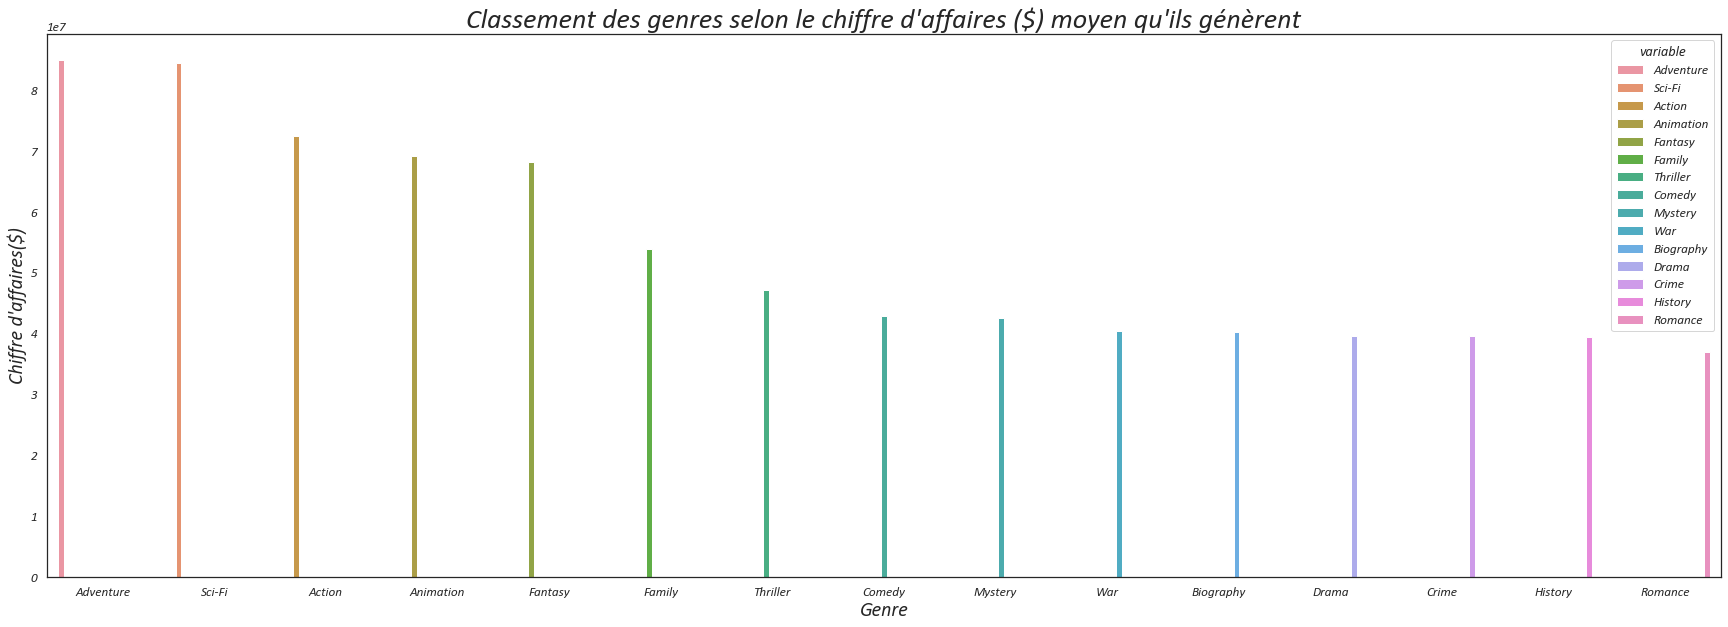

In [43]:
x=df_genre['variable']
y=df_genre['CA($)']

fig, ax = plt.subplots(figsize = (30,10))
sns.barplot(ax=ax, x=x, y=y, hue=df_genre.variable)
ax.set_title("Classement des genres selon le chiffre d'affaires ($) moyen qu'ils génèrent", fontsize = 28)
ax.set_xlabel('Genre', fontsize = 20)

ax.set_ylabel("Chiffre d'affaires($)", fontsize = 20)

plt.show()

On observe ici que les genres qui génèrent en moyenne le plus de chiffres d'affaires sont :
- Adventure
- Science fiction
- Action
- Animation

On sait que plus le nombre d'entrées est élevé pour un film, plus son chiffre d'affaire sera important. Nous choisissons donc de mesurer le 'succés' d'un film avec le chiffre d'affaire qu'il a engendré. 

Le but de la suite de cette sous-partie est de regarder les genres les plus rentables et à succès dans les dernières années, pouvant donc expliquer une variabilité de la fréquentation.

Nous créons quelques programmes intermédiaires.

In [44]:
def tableau_genre(genre) :
  df_moyen = df_Genre_oneHot.set_index(genre)
  df_moyen = df_moyen.drop(colonne==0)
  return(df_moyen)

# On classe ce tableau par année 
def tableau_genre_trie_année(genre): 
  tableau_trié = tableau_genre(genre).sort_values(by = 'Année')
  return tableau_trié
#print(tableau_genre_trie_année('Drama'))

# Liste des moyennes de chiffres d'affaire pour chaque genre 
def evolution_CA(genre) : 
  E = []
  for k in range(1950, 2020) :
    T = tableau_genre(genre)[tableau_genre(genre)['Année'] == k]
    #print(T)
    E.append(T['CA($)'].mean())
  return(E)

In [45]:
# On créé alors un tableau avec l'évolution des chiffres d'affaires moyen par an pour chaque genre prédéfini. 

L = [k for k in range(1950, 2020)]
tableau = pd.DataFrame({'Année':L })

for genre in Mots :
  tableau[genre] = evolution_CA(genre)
tableau

,Année,Drama,Comedy,Action,Thriller,Adventure,Biography,Sci-Fi,Fantasy,History,Animation,Crime,War,Mystery,Family,Romance
0,1950,NaN,NaN,2.836892e+07,8.500000e+07,NaN,NaN,2.836892e+07,NaN,NaN,NaN,NaN,NaN,1.017700e+04,NaN,NaN
1,1951,4.159003e+06,7.630000e+06,3.969893e+06,5.489964e+06,NaN,NaN,8.000000e+06,NaN,5.361180e+05,NaN,NaN,NaN,4.500000e+06,NaN,7.630000e+06
2,1952,NaN,7.430800e+04,9.134514e+06,NaN,9.450000e+06,NaN,8.819028e+06,NaN,NaN,NaN,4.446668e+06,NaN,NaN,NaN,9.450000e+06
3,1953,4.375130e+07,1.529897e+07,NaN,1.828667e+07,NaN,NaN,4.360000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.740465e+07
4,1954,9.302925e+06,2.820000e+07,4.097495e+06,3.676431e+07,4.934530e+06,1.500628e+07,2.423423e+06,1.300000e+06,1.300000e+06,2.820000e+07,1.493300e+07,NaN,3.676431e+07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2015,3.835160e+07,4.552303e+07,1.042724e+08,7.575296e+07,1.264479e+08,2.857690e+07,1.830184e+08,3.292117e+07,2.939968e+07,9.366624e+07,2.765713e+07,1.141316e+08,4.546742e+07,5.498740e+07,3.893647e+07
66,2016,4.020218e+07,4.875852e+07,9.048517e+07,4.818486e+07,1.256270e+08,3.664434e+07,9.971327e+07,1.071358e+08,2.187659e+07,1.169683e+08,2.562890e+07,6.928917e+06,3.513594e+07,1.716204e+08,3.638662e+07
67,2017,4.507777e+07,5.858896e+07,1.071773e+08,4.553537e+07,1.426998e+08,4.260370e+07,7.550318e+07,1.324089e+08,6.334946e+07,7.810829e+07,5.380803e+07,2.778008e+07,5.588288e+07,7.273300e+07,4.183752e+07
68,2018,6.467475e+07,3.802295e+07,8.697666e+07,5.301060e+07,1.182010e+08,7.683958e+07,1.278212e+08,9.540716e+07,1.218940e+08,6.584398e+07,4.491679e+07,1.534360e+08,2.806211e+07,6.353505e+07,4.711039e+07


Ce tableau nous donne comme voulu l'évolution du 'succés' de chaque genre en fonction des années, succès mesuré par le chiffre d'affaires.

On observe la présence de `Nan` mais nous considérons que ceux-ci ne sont pas dérangeants : ils nous indiquent au contraire que certaines années, des genres n'ont pas été représentés à l'écran. 

Ces `Nan` nous permettent également de remarquer que certains genres paraissaient inexistants dans les années 1950 et 1960 et semblent apparaitre au fur et à mesure. **La diversité des genres augmentent.** 

De plus, on a montré dans la partie 2 que l'offre au cinéma avait fortement augmenté avec les années, ce qui pouvait expliquer en partie en regain de la fréquentation malgré l'augmentation du prix de la place de cinéma. 

Pour compléter cette remarque, on montre ici que l'offre est devenue de plus en plus variée avec l'apparition de certains genres au fil des années, ce qui a pu aussi attirer de plus en plus de personnes. 

**Ce propos reste à nuancer** : comme il a été montré précédemment, notre base de données contient plus de films récents que de films anciens. Les conclusions peuvent donc être biaisées par l'absence de films plus anciens dans notre base de données. Cependant, nous savons aussi que l'offre au cinéma augmente, ce ne serait donc pas si surprenant que la variété des genres augmente également.  



**Nous avons donc décidé par la suite de réduire nos observations aux 20 dernières années.**

En effet, nous avons observé précédemment une légère reprise de la fréquentation des cinémas en France et comme il a été dit, une plus grande diversité des genres. 

On peut donc s'intéresser au 'genre dominant' par année, soit celui qui a généré le plus de chiffre d'affaires en moyenne. C'est ce que nous allons faire dans les cellules suivantes. 

In [46]:
tableau_1990 = tableau[tableau['Année'] > 1989] # On s'intéresse aux 30 dernières annéespd.DataFrame(y).transpose()

tableau_1990_2 = tableau_1990.set_index('Année')
y_2 = tableau_1990_2.idxmax(axis=1)
tableau_final = pd.DataFrame(y_2).reset_index()
tableau_final =pd.DataFrame({'Année':tableau_final['Année'],'Genre le plus rentable':tableau_final[0]}).set_index('Année')
tableau_final

,Genre le plus rentable
Année,
1990,Family
1991,Fantasy
1992,Comedy
1993,Sci-Fi
1994,Animation
1995,Animation
1996,History
1997,Sci-Fi
1998,War


In [47]:
tableau_final['Genre le plus rentable'].value_counts() # On regarde l'occurence de chaque genre dans notre tableau 

Sci-Fi       8
Animation    5
Adventure    4
War          3
Family       3
Fantasy      3
Mystery      1
Comedy       1
Action       1
History      1
Name: Genre le plus rentable, dtype: int64

On a montré ici que les films qui ont eu globalement le plus de succès (soit ceux qui ont eu le plus gros chiffre d'affaire) sont les films appartenant aux genres suivants :

- Science fiction
- Animation
- Aventure

**Ceci montre que les gens continuent à aller au cinéma surtout pour des grosses productions américaines, plus spectaculaires à l'écran, ou bien pour des films d'animation, souvent associés à des moments en famille.**

On peut donc penser que les films appartenant à d'autres genres ont plus de succès sur les plateformes de vidéo à la demande, mais ceci reste une supposition.

### 2) Étude des réalisateurs

Nous allons maintenant s'intéresser aux réalisateurs, et regarder ceux qui ont réalisé des films ayant généré des chiffres d'affaires importants. 

In [48]:
# Moyenne des chiffres d'affaires pour chaque réalisateur 

tableau_realisateur = df["Réalisateur"].unique()
len(tableau_realisateur)
tableau_realisateur
type(tableau_realisateur)
R = list(tableau_realisateur)


# Programme qui permet d'afficher les films d'1 seul réalisateur

def groupe_réalisateur(i) :
    df_bis = df[df['Réalisateur'] == i]
    return df_bis

# Fais la moyenne des chiffres d'affaires pour un seul réalisateur

def chiffre_affaire_moyen(i) :
      return groupe_réalisateur(i)['CA($)'].mean()

# On crée la liste des moyennes des chiffres d'affaire pour chaque réalisateur 

L = []
for i in tableau_realisateur :
      L.append(chiffre_affaire_moyen(i))

def metascore_moyen(i) :
      return groupe_réalisateur(i)['Metascore'].mean()

M = []
for i in tableau_realisateur:
      M.append(metascore_moyen(i))

def Score_public_moyen(i) :
      return groupe_réalisateur(i)['Score imdb'].mean()

S = []
for i in tableau_realisateur:
      S.append(Score_public_moyen(i))

# On crée le tableau avec les réalisateurs et leur chiffre d'affaire moyen sur l'ensemble de leurs films

data = [R,L,M,S]
index = ['Réalisateur','Chiffre d affaire moyen','Metascore moyen','Score public moyen']
df_rea_CAmoyen = (pd.DataFrame(data=data,index=index)).T
rea_CAmoyen_trie = df_rea_CAmoyen.sort_values(by=['Chiffre d affaire moyen'],ascending=False)
VRAI = rea_CAmoyen_trie.dropna()
VRAI.head(10)


,Réalisateur,Chiffre d affaire moyen,Metascore moyen,Score public moyen
347,"Andrew Stanton, Angus MacLane",4.86296e+08,77,73
110,"Chris Buck, Jennifer Lee",4.39056e+08,69.5,71.5
178,"Andrew Adamson, Kelly Asbury, Conrad Vernon",4.36471e+08,75,72
426,Josh Cooley,4.34038e+08,84,78
27,"Roger Allers, Rob Minkoff",4.22784e+08,88,85
52,Lee Unkrich,4.15005e+08,92,83
25,"Andrew Stanton, Lee Unkrich",3.80843e+08,90,81
44,"Anthony Russo, Joe Russo",3.80167e+08,66.3333,73.8333
466,"Chris Renaud, Yarrow Cheney",3.68384e+08,61,65
39,J.J. Abrams,3.66568e+08,70.8333,73.3333


**Nous vérifions tout d'abord une des conclusions obtenues en Partie 1** : les réalisateurs générant en moyenne un très haut chiffre d'affaires obtiennent en effet des scores bien au-dessus des moyennes (celles-ci étant établies à 57 pour le métascore et 65 pour le score imdb). 

Cependant nous remarquons le même problème que pour les genres, il existe des 'combinaisons' de réalisateurs ce qui ne permet pas exactement de classer les réalisateurs pour la totalité de leur oeuvre. En effet les groupes de réalisateurs travaillent généralement ponctuellement ensemble sur un ou deux films à gros budgets. On peut citer Andrew Stanton et Lee Unkrich qui sont deux réalisateurs des studios Pixar par exemple. 

Nous allons donc procéder au même traitement que pour les genres en utilisant du **One hot encoding de données textuelles**. 

Nous choisissons cette fois de sélectionner les réalisateurs ayant réaliser le plus de films.

In [49]:
import operator
temp=[]
def countreal(a):
    temp.append(a.split(", "))
    return temp
b=df['Réalisateur'].apply(countreal)

real=[]
for a in b[0]:
    for d in a:
        real.append(d)
freq={i:real.count(i) for i in set(real)}
sort = sorted(freq.items(), key=operator.itemgetter(1), reverse=True)

top_real=[]
for a in sort[0:15]:
    top_real.append(a[0])
    
top_real

['Clint Eastwood',
 'Woody Allen',
 'Steven Spielberg',
 'Martin Scorsese',
 'Ridley Scott',
 'Ron Howard',
 'Steven Soderbergh',
 'Robert Zemeckis',
 'Tim Burton',
 'Richard Linklater',
 'Joel Coen',
 'Christopher Nolan',
 'Ethan Coen',
 'Brian De Palma',
 'Barry Levinson']

In [50]:
def one_hot_Real (df, top_real):
    
    
    A = df.copy()
    
    # Crée de nouvelles colonnes qui serviront pour le 1 hot encoding des genres
    for real in top_real:
        df[real] = 0 # Initilise à 0 pour tous les genres
    A['Autre'] = 0
        
    # On parcourt ensuite les lignes du dataframe et on vérifie la présence de chaque genre 
    
    for index, realisateur in enumerate(df.Réalisateur):
    
        indefini = True
        if type(realisateur) == str :
            for real in top_real :
                if real in realisateur :
                    indefini = False
                    df.loc[index, real] = 1
        #elif indefini :
         #   df.loc[index, 'Autre'] = 1
    
    return df

In [51]:
OneHotReal = one_hot_Real(df, top_real)
OneHotReal=OneHotReal.drop(['Réalisateur'],axis=1)
OneHotReal=OneHotReal.reset_index()
#OneHotFull=OneHotReal.dropna().merge(df_Genre_oneHot[Mots+['Film']], on='Film').drop('index',axis=1)
    


<ipython-input-50-a6bc45dbb721>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[real] = 0 # Initilise à 0 pour tous les genres
C:\Users\Clara\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-50-a6bc45dbb721>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [52]:
df_real = OneHotReal.set_index('Film')
df_real = df_real.melt(id_vars= ['CA($)','Année','Metascore','Score imdb'], value_vars=top_real)
df_real=df_real[df_real.value==1.0].set_index('variable').drop(['value','Année'],axis=1)
df_real=df_real.groupby('variable').mean()
df_real=df_real.reset_index()
df_real=df_real.sort_values(by='CA($)',ascending=False).reset_index().drop('index',axis=1)
df_real

,variable,CA($),Metascore,Score imdb
0,Christopher Nolan,1.546025e+08,71.000000,77.071429
1,Steven Spielberg,1.453944e+08,63.258065,72.516129
2,Tim Burton,9.320390e+07,62.588235,70.294118
3,Robert Zemeckis,8.813312e+07,64.235294,73.588235
4,Ron Howard,8.476379e+07,58.086957,68.782609
5,Steven Soderbergh,7.609368e+07,60.000000,67.833333
6,Ridley Scott,7.009505e+07,66.320000,70.560000
7,Clint Eastwood,5.636517e+07,62.033333,69.700000
8,Martin Scorsese,5.564383e+07,69.545455,72.500000
9,Ethan Coen,4.976040e+07,64.000000,70.882353


Nous obtenons ici la liste des 15 réalisateurs qui ont réalisé le plus de films, classée par ordre de chiffre d'affaire moyen croissant, accompagné de leurs scores moyens, toujours relativement élevés.



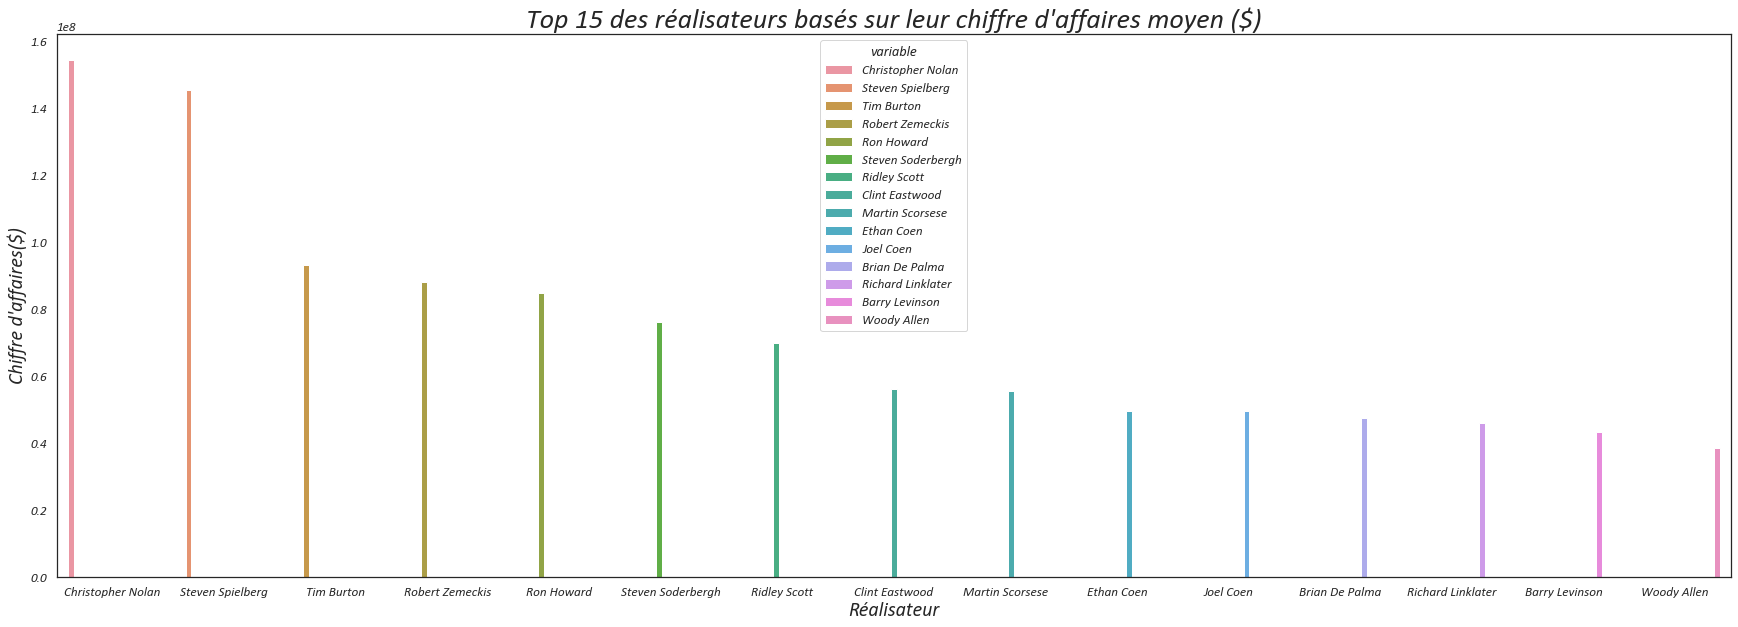

In [53]:
x=df_real['variable']
y=df_real['CA($)']

fig, ax = plt.subplots(figsize = (30,10))
sns.barplot(ax=ax, x=x, y=y, hue=df_real.variable)
ax.set_title("Top 15 des réalisateurs basés sur leur chiffre d'affaires moyen ($)", fontsize = 28)
ax.set_xlabel('Réalisateur', fontsize = 20)

ax.set_ylabel("Chiffre d'affaires($)", fontsize = 20)

plt.show()

Les voici maintenant sous forme de graphique. 

Les résultats coïncident avec ceux obtenus sur les genres (plutôt rassurants puisqu'on avait aussi aussi mesuré le 'succès' d'un film avec le chiffre d'affaires généré). En effet, on sait qu'un réalisateur comme Steven Spielberg réalise plutôt des films de science-fiction et d'aventure. Christopher Nolan a realisé la trilogie des Batman ainsi que des films de Science-fiction. Tim Burton réalise de nombreux films d'animation. Quant à Robert Zemeckis, il a notamment réalisé la trilogie des Retour vers le Futur. 

Ainsi notre analyse sur les réalisateurs non seulement confirme notre étude sur les genres à succès mais apporte une nouvelle information. En effet, il semble que le public tende à suivre les sorties des réalisateurs à succès, notamment lorsqu'il s'agit de sagas.

#### Bref retour au cas français

Nous avons donc précédemment étudié ce qui pouvait faire des films de notre base des succès aux Etats-Unis, notamment ces dernières décennies. Il nous semble cohérent de considérer qu'un important succès aux Etats-Unis donnera lieu à un important succès en France. Nous connaissons par exemple le succès de Christopher Nolan ou Steven Spielberg auprès du public français. 

Nous allons catégoriser ces films comme 'films américains' afin de les comparer aux films français. 

**Nous allons donc étudier le nombre d'entrées que génèrent les films français et les films américains en France chaque décennie depuis 1950.**


Text(0.5, 0, 'Décennies')

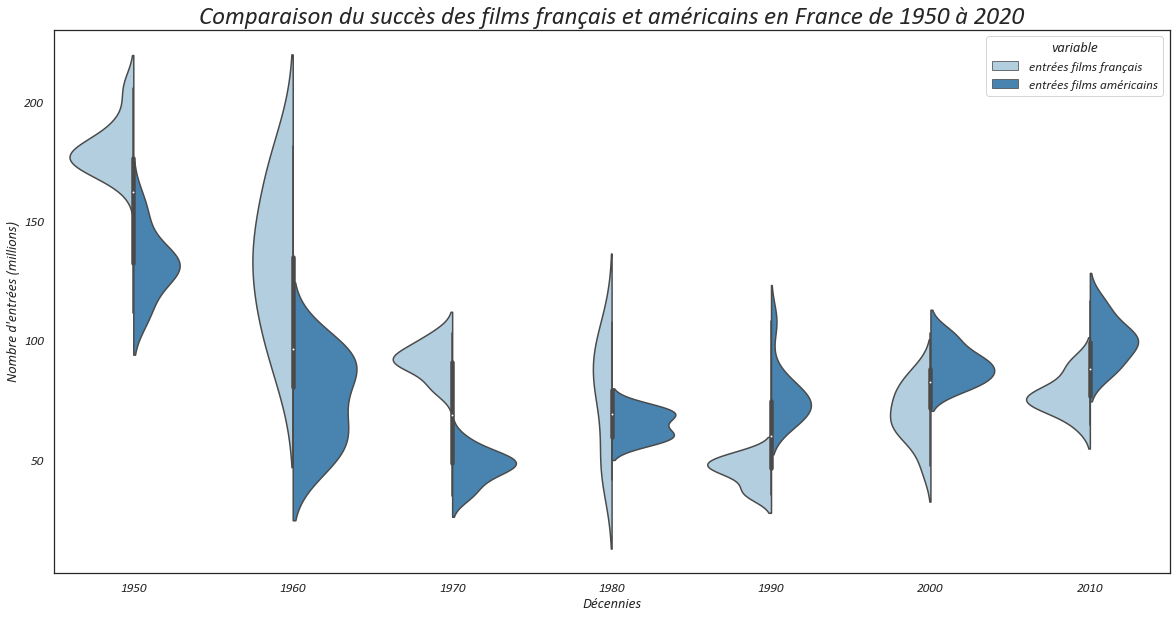

In [54]:
DF_violin = DF_entrées.melt(id_vars =['Décennie'], value_vars =['entrées films français','entrées films américains'])
plt.figure(figsize=(20,10))
sns.violinplot(data = DF_violin, x='Décennie', y='value',hue='variable',split=True, palette='Blues')
plt.title("Comparaison du succès des films français et américains en France de 1950 à 2020", fontsize = 25)
plt.ylabel("Nombre d'entrées (millions)")
plt.xlabel("Décennies")

Premièrement nous observons que les deux genres ont toujours été présents et regardés dans les cinémas français mais que la décennie 1980 a été un point de basculement. En effet après cette dernière, les films américains sont majoritaire dans le box-office français. Cela ne nous étonne guère au vu de la place centrale d'Hollywood dans la production cinématographique. 

Néanmoins le nombre d'entrées moyen des films français reste toujours assez proche de l'américain et à une dispersion moindre. 

**Cela est très positif et montre que le cinéma français est loin de se faire écraser par Hollywood dans le box-office national.**

**Vérifions ce qui a provoqué des pics de fréquentation ces dernières années en France.**

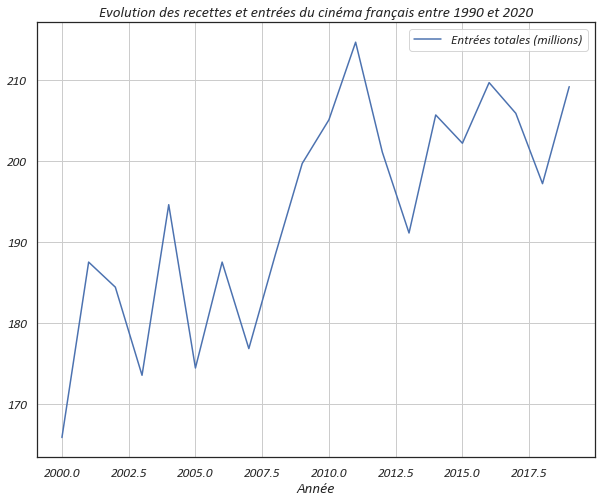

In [58]:
fig = plt.figure(figsize=(10,8))
DF_entrées_2000_2020 = DF_entrées[DF_entrées.Année>=2000]

DF_entrées_2000_2020 = DF_entrées_2000_2020.set_index('Année')


ax1 = plt.subplot(1,1,1)
#On plotte sur le même graphe la plupart des caractéristiques de notre jeu de données
ax1 = plt.plot(DF_entrées_2000_2020['Entrées totales (millions)'], marker='', linestyle ='solid', label='Entrées totales (millions)')

plt.grid('y')

plt.xlabel("Année", fontsize = 15)
#plt.ylabel("", fontsize = 15)
plt.legend(loc='best')
plt.title("Evolution des recettes et entrées du cinéma français entre 1990 et 2020", fontsize=15)
plt.show()

Nous voyons ici de plus près la forte variabilité de fréquentation. Nous pouvons alors les comparer au box-office français ces années là. Nous n'avons pas de bases de données exploitables mais nous regardons quelques années références sur internet. 

- Nous retrouvons régulièrement Harry Potter dans le box-office (n°1 en 2001, n°3 en 2004, n°2 en 2009) ainsi que Star Wars et le Seigneur des Anneaux. Nous retrouvons également beaucoup de films d'animation tels que L'âge de glace (n°1 en 2009) ou encore Toy Story. Ces succès nous confirment le succès des sagas américaines, notamment dans les genres d'animation et de science-fiction. 

- Néanmoins nous retrouvons régulièrement des comédies françaises en tête du box-office : Les Bronzés 3 (n°1 en 2006), Bienvenue chez les ch'tis (n°1 en 2008), Intouchables (record sorti en 2011). 

**Ainsi le public français semble sensible au box-office américain tout en continuant toujours d'aller voir en masse les films français, notamment les comédies, en salle.**



# Conclusion 

Après avoir fait un état des lieux de la base IMDb et constaté une augmentation du chiffre d'affaires annuel moyen des films aux Etats-Unis, nous avons notamment trouvé, en France, une augmentation du chiffre d'affaires des cinémas mais pourtant une baisse de leur fréquentation de 1950 aux années 1990.. 

Nous avons tout d’abord remarqué que le prix du billet augmentait lui aussi chaque année ce qui semble être un frein chez les 15-40 ans sans toucher les populations plus âgées pour qui le billet de cinéma ne peut être assimilé à un bien ordinaire. Nous étions cependant étonnées de découvrir que cette croissance du prix n'impactait pas différemment les différentes classes socio-professionnelles. Par ailleurs, alors que nous pensions que le succès croissant des plateformes de streaming aurait une influence directe sur la fréquentation des cinémas, nous observons que les années 2000 sont synonymes d’une légère reprise du nombre d’entrées qui reste très variable chaque année. Nous avons suggéré que cette reprise pourrait être liée à l’augmentation du nombre de films distribués chaque année, visible à partir des années 1990.

En effet, les français semblent toujours préférer consommer certains genres de films dans une salle de cinéma. Ainsi la fréquentation en salle annuelle sera extrêmement sensible à quelques sorties. En France, les pics de fréquentation des dix à vingt dernières années sont généralement associés à de grosses productions américaines de fantastique/science-fiction/animation, généralement des sagas (Harry Potter, Star Wars, Toy Story, L’age de glace, …) ou bien des comédies françaises qui décrochent toujours des premières places au box-office (Intouchables, Les Tuche, Les bronzés, ...). 

Finalement, nous observons que le cinéma garde une place centrale dans les habitudes culturelles des français. Bien que l’introduction de télévision dans les années 1960 ait considérablement réduit le temps accordé par les français aux ‘sorties ciné’, la privatisation de celle-ci dans les années 1980 puis l’arrivée du streaming dans les années 2000 n’ont pas enlevé l’envie du public de consommer les films les plus populaires et les plus spectaculaires sur un écran géant.   
 